In [2]:
# standard libs
from datetime import datetime, timedelta
from pathlib import Path
import os, json, time
from pprint import pprint

# math and data
import numpy as np
import scipy
from scipy import constants
import pandas as pd
import h5py

# visualization
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 300em; }</style>"))

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

try:
    %matplotlib inline
    show_tag = True
except:
    show_tag = False
    print("no ipython backend")
    
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import plotly.express as px
import qgrid

py.init_notebook_mode()

plt.rcParams['figure.figsize'] = (10, 4)

# this package
%load_ext autoreload
%autoreload 2
from fhds import fhds, interface
from fticr_toolkit import *

from scipy.optimize import curve_fit
plt.rcParams['figure.figsize'] = (20, 8)
from pprint import pprint
#pprint(meas_config)
from scipy.signal import freqz
from scipy.signal import butter, lfilter
import allantools as at

### WARNING !!! ###
# this will remove the warnings from pandas regarding assignments of copies of DataFrames to the other/same DataFrames. This
# is fine regarding the features implemented, but if you change stuff and its not working out as you think, you should 
# enable this again, to check if this is the problem.
pd.options.mode.chained_assignment = None  # default='warn'
# define floating points on display, this will be changed later to higher precision
pd.options.display.float_format = '{: .3f}'.format

# Get comparison data and config from the measurement (axial fits from part 1)

In [3]:
###   P A R A M E T E R   L I S T   ( this is especially used for batch processing using the papermill package but its also nice to have thesse parameters all at one place )
measurement_folder = "E:\\local_analysis\\Yb\\176Yb43+_174Yb43+_176Yb43+_feedback_asym_3"

input_folder = "./part1_data/" # the measurements subfolder where the pre-analysed data was saved (output of PART 1: spectra fits and/or phases) 

output_folder = "./results/" # subfolder where the results of this analysis should go

# analysis parameters are loaded from a (more static and measurement specific) settings file ('analysis_settings.json') inside the measurement folder
# for testing and batch processing the parameters can be adjusted below
settings = {
    # The filter settings are used to remove some data, which is nice if e.g. the ion was lost at some point and you dont want to see crappy random data. Either directly supply a pandas dset (more usefull for papermill batches) or rather
    # create a csv file as in the examples and just assign None to this variable, it will use the csv file then. 
    "filter_settings": False, # pandas dset with mc, trap, position, min_cycle, max_cycle; None: try to get filter settings from loaded data; False: no filter applied
    #"filter_settings": pd.DataFrame(
    #    columns=["mcycle", "trap", "position", "min_cycle", "max_cycle"],
    #    data=[[1,2,"position_1", 0, 26],[1,2,"position_2", 0, 26],[1,3,"position_1", 0, 26],[1,3,"position_2", 0, 26]]
    #          ),
    "post_unwrap": True, # if this is True, the analysis will automatically choose the post-unwrap (the pre-unwrap of the next main cycle) for nu_p frequency determination. Maybe the whole post-unwrap part is commented out in step 5, please check.
    "mean_ref_phase": False, # BUGGED!!!! DONT USE! if True, the reference phase will be averaged and the same value substracted for all long phases (not in Ndet), otherwise every single measured reference phase is substraced from the respective long phase
    "phase_filter": True, # filter measured phases by 3 sigma filter inside subcycle
    "single_axial": False, # use single spec no average axial data
    "averaging": True, # averaging subcycle data to match average_idx from part 1
    "nu_z_from_config": False, # default: False, if float, the config nu_z will be taken and the float value is used as the error on the config nu_z
    "fill_nu_z_from_config": 0.08, # default: False, if float, the config nu_z will be taken if the measured nu_z is off by hardcoded 100 Hz (which also includes no value at all) and the float value is used as the error on the config nu_z
    "sideband": False, # use sideband relation to calculate nu_c
    "polydegrees": 'auto', # number of degree of the polynom fit
    "polygrouping": 'auto', # group sizes for the polynom fit
    "poly_mode": "curvefit", # routine for polynom fitting
    "poly_criterion": "AICc", # criterion for best model/poly-degree
    "invert": False,
}

In [3]:
data, meas_config, results_dir = data_conversion.load_data(measurement_folder=measurement_folder,
                                              input_data=input_folder, # inside measurement folder
                                              output_folder=output_folder, # inside measurement folder
                                              measurement_script = "unwrap_n_measure_repeat") # inside measurement folder

try:
    settings_from_file = data_conversion.load_settings(measurement_folder)
    settings_from_file.update( settings )
    settings = settings_from_file
except:
    print("no settings from file!")
print("settings", settings)
#print("invert? (default=True)", settings['invert'])

try:
    data = data_conversion.input_filter(data, settings=settings["filter_settings"])
except:
    raise
    print("no input filter")

# define local namespace names for the data, just easier
nu_p_unwrap = data["pre_unwrap_phase"]
nu_p_phases = data["phase_data"]
axial_data = data["axial_data"]

if settings.get("single_axial", False):
    axial_data = data["axial_data_single"]

# get the variables/lists we will be looping over...
mcs = nu_p_unwrap.mcycle.unique()
print(" >>> MAIN CYCLES: ", mcs)
super_cycle_list = []
for mc in mcs:
    subset = axial_data[axial_data['mcycle']==mc]
    subcycles = subset.cycle.unique()
    super_cycle_list.append(list(subcycles))
print(" >>> SUB CYCLES: ", super_cycle_list, "\n")
positions = axial_data.position.unique()
print(positions)
start_position = meas_config["start_position"]
other_position = positions[0]
if start_position == other_position:
    other_position = positions[1]
    
axial_data['nu_distance'] = axial_data['nu_z'] - axial_data['nu_res']
axial_data['dnu_distance'] = np.sqrt(axial_data['dnu_z'].to_numpy()**2 + axial_data['dnu_res'].to_numpy()**2)
    
print(" >>> POSITIONS: ", positions, " - > start at", start_position)
traps = axial_data.trap.unique()
print(" >>> TRAPS:     ", traps)

if show_tag:
    # ...and just roughly check the data...
    print(" >>> AXIAL DATA >>> ")
    #axial_data = axial_data[ (axial_data['mcycle']==1) & (axial_data['cycle'] >= 0) ]
    #fig = px.scatter(axial_data, x="time", y="nu_z", error_y="dnu_z", facet_row="position", facet_col="trap", hover_data=['mcycle', 'cycle', 'position'])
    fig = px.scatter(axial_data, x="time", y="nu_z", error_y="dnu_z", facet_col="trap", color="position", hover_data=['mcycle', 'cycle', 'position'])
    fig.update_yaxes(matches=None, showticklabels=True)
    fig.show()
    #display(axial_data)
    
    # ...and just roughly check the data...
    print(" >>> RES DATA >>> ")
    #axial_data = axial_data[ (axial_data['mcycle']==1) & (axial_data['cycle'] >= 0) ]
    #fig = px.scatter(axial_data, x="time", y="nu_z", error_y="dnu_z", facet_row="position", facet_col="trap", hover_data=['mcycle', 'cycle', 'position'])
    fig = px.scatter(axial_data, x="time", y="nu_res", error_y="dnu_res", facet_col="trap", color="position", hover_data=['mcycle', 'cycle', 'position'])
    fig.update_yaxes(matches=None, showticklabels=True)
    fig.show()
    #display(axial_data)
    
    print(" >>> diff DATA >>> ")
    #axial_data = axial_data[ (axial_data['mcycle']==1) & (axial_data['cycle'] >= 0) ]
    #fig = px.scatter(axial_data, x="time", y="nu_z", error_y="dnu_z", facet_row="position", facet_col="trap", hover_data=['mcycle', 'cycle', 'position'])
    fig = px.scatter(axial_data, x="time", y="nu_distance", error_y="dnu_distance", facet_row="position", facet_col="trap", hover_data=['mcycle', 'cycle', 'position'])
    fig.update_yaxes(matches=None, showticklabels=True)
    fig.show()
    #display(axial_data)
    
    """ Allen Deviation for axial
    for trap, data in axial_data.groupby("trap"):
        data = data.sort_values("time")
        data['epoch'] = data["time"].astype("int64")//1e9
        data['seconds'] = data['epoch'] - data['epoch'].min()
        t = data.seconds.to_numpy()/60
        y = data.nu_z.to_numpy()
        y = y/np.mean(y)
        visualization.allanvariance(y, t, plot=True)
    """

    print(" >>> PHASE DATA >>> ")
    nu_p_phases["acc_time"] = nu_p_phases["acc_time"].astype(str)
    fig = px.scatter(nu_p_phases, x="time", y="phase", facet_row="trap", facet_col="position", color="acc_time", hover_data=['mcycle', 'cycle', 'position'])
    #fig = px.scatter(nu_p_phases, x="time", y="phase", facet_row="position", facet_col="trap", color="acc_time", hover_data=['mcycle', 'cycle', 'position'])
    #fig = px.scatter(nu_p_phases, x="time", y="phase", facet_col="trap", color="position", hover_data=['mcycle', 'cycle', 'position'])
    fig.show()
    nu_p_phases["acc_time"] = nu_p_phases["acc_time"].astype(float)

    print(" >>> PHASE DIFFERENCE START POSITION - OTHER POSITION >>> ")
    try:
        nu_p_phases["acc_time"] = nu_p_phases["acc_time"].astype(str)
        posA = nu_p_phases[nu_p_phases["position"] == start_position]
        posB = nu_p_phases[nu_p_phases["position"] != start_position]
        posA["phase_diff"] = posA.phase.to_numpy() - posB.phase.to_numpy()
        fig = px.scatter(posA, x="time", y="phase_diff", facet_row="trap", facet_col="position", color="acc_time", hover_data=['mcycle', 'cycle', 'position'])
        fig.show()
    except Exception as e:
        print(e)
        print(' DIFF only works with equal size phase data')
    finally:
        nu_p_phases["acc_time"] = nu_p_phases["acc_time"].astype(float)
        
    print(" >>> UNWRAP DATA >>> ")
    nu_p_unwrap["acc_time"] = nu_p_unwrap["acc_time"].astype(str)
    fig = px.scatter(nu_p_unwrap, x="time", y="phase", facet_col="trap", facet_row="position", color="acc_time", hover_data=['mcycle', 'cycle', 'position'])
    fig.show()
    nu_p_unwrap["acc_time"] = nu_p_unwrap["acc_time"].astype(float)
    
    """
    # trap2
    t2_phases = nu_p_unwrap[ (nu_p_unwrap['trap']==2) & (nu_p_unwrap['position']=='position_2') ]
    #display(t2_phases)
    accs = []
    pstds = []
    for name, group in t2_phases.groupby(['mcycle', 'acc_time']):
        accs.append( float(group.acc_time.unique()) )
        pstds.append( np.std( np.unwrap( group.phase.to_numpy() ) ) /2/np.pi*360 )
    plt.scatter(accs, pstds, marker='o')
    plt.show()
    
    t3_phases = nu_p_unwrap[ (nu_p_unwrap['trap']==3) & (nu_p_unwrap['position']=='position_2') ]
    #display(t3_phases)
    accs = []
    pstds = []
    for name, group in t3_phases.groupby(['mcycle', 'acc_time']):
        accs.append( float(group.acc_time.unique()) )
        pstds.append( np.std( np.unwrap( group.phase.to_numpy() ) ) /2/np.pi*360 )
    plt.scatter(accs, pstds, marker='o')
    plt.show()
    """


 >>> WARNING!!! output_folder already exists! files will maybe be overwritten! <<< 


 >>> I hope you are in PART2 or 3, loading pre analysed data from folder... <<< 

settings {'filter_settings': False, 'post_unwrap': True, 'mean_ref_phase': False, 'phase_filter': True, 'single_axial': False, 'averaging': True, 'nu_z_from_config': False, 'fill_nu_z_from_config': 0.08, 'sideband': False, 'polydegrees': 'auto', 'polygrouping': 'auto', 'poly_mode': 'curvefit', 'poly_criterion': 'AICc', 'invert': False}
 >>> MAIN CYCLES:  [1 2]
 >>> SUB CYCLES:  [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], [1, 2, 3, 4, 5, 6]] 

['position_1' 'position_2']
 >>> POSITIONS:  ['position_1' 'position_2']  - > start at position_2
 >>> TRAPS:      [2 3]
 >>> AXIAL DATA >>> 


 >>> RES DATA >>> 


 >>> diff DATA >>> 


 >>> PHASE DATA >>> 


 >>> PHASE DIFFERENCE START POSITION - OTHER POSITION >>> 
operands could not be broadcast together with shapes (840,) (834,) 
 DIFF only works with equal size phase data
 >>> UNWRAP DATA >>> 


# Get analog data for ring down fits

In [4]:
import pandas as pd
import glob

path = r'' # use your path
all_files = glob.glob(measurement_folder + "\\analog_data\\*.csv")

print(all_files[0])


E:\local_analysis\Yb\176Yb43+_174Yb43+_176Yb43+_feedback_asym_3\analog_data\ch1_size_192000_off_-1920_20220125_184812.csv


In [5]:
#print(all_files)

# size_19200_off_-1920_20211229_115225

anadata = pd.DataFrame()

for filename in all_files:
    fname = filename.split("\\")[-1]
    #print(fname)
    ch = fname.split("_")[0][2]
    date = fname.split("_")[-2]
    time = fname.split("_")[-1][:-4]
    dstring = date+"_"+time
    dtime = datetime.strptime(dstring, '%Y%m%d_%H%M%S')
    #print(ch, date, time, dtime)
    
    row = pd.Series(data={"ch": ch, "dtime": dtime, "fname": filename})
    anadata = anadata.append(row, ignore_index=True)

In [6]:
anadata["dtime"] = pd.to_datetime(anadata["dtime"])
anadata["seconds"] = (anadata["dtime"] - anadata["dtime"].min()).dt.total_seconds()
secs = anadata["seconds"].to_numpy()
dsecs = secs[1:] - secs[:-1]
dsecs = np.insert(dsecs, 0, 0)
anadata["dseconds"] = dsecs
display(anadata)



ch               dtime  \
0     1 2022-01-25 18:48:12   
1     1 2022-01-25 18:49:36   
2     1 2022-01-25 18:49:49   
3     1 2022-01-25 18:51:12   
4     1 2022-01-25 18:51:24   
...  ..                 ...   
1781  2 2022-01-26 09:47:33   
1782  2 2022-01-26 09:48:57   
1783  2 2022-01-26 09:49:09   
1784  2 2022-01-26 09:50:33   
1785  2 2022-01-26 09:50:45   

                                                  fname    seconds  dseconds  
0     E:\local_analysis\Yb\176Yb43+_174Yb43+_176Yb43...      0.000     0.000  
1     E:\local_analysis\Yb\176Yb43+_174Yb43+_176Yb43...     84.000    84.000  
2     E:\local_analysis\Yb\176Yb43+_174Yb43+_176Yb43...     97.000    13.000  
3     E:\local_analysis\Yb\176Yb43+_174Yb43+_176Yb43...    180.000    83.000  
4     E:\local_analysis\Yb\176Yb43+_174Yb43+_176Yb43...    192.000    12.000  
...                                                 ...        ...       ...  
1781  E:\local_analysis\Yb\176Yb43+_174Yb43+_176Yb43...  53961.000    12.000  
1782  E:\local_analysis\Yb\176Yb43+_174Yb43+_176Yb43...  54045.000    84.000  
1783  E:\local_analysis\Yb\176Yb43+_174Yb43+_176Yb43...  54057.000    12.000  
1784  E:\local_analysis\Yb\176Yb43+_174Yb43+_176Yb43...  54141.000    84.000  
1785  E:\local_analysis\Yb\176Yb43+_174Yb43+_176Yb43...  54153.000    12.000  

[1786 rows x 5 columns]

In [7]:
qgrid_widget = visualization.filter_grid(anadata)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

### data access functions

In [8]:
# data access functions

def getdata(fname):
    arr = np.genfromtxt(fname, delimiter=',')
    return arr[:,0], arr[:,1]

def cut(x,y,start,length):
    idxes = np.where((x-start)>0)
    x = x[idxes]
    y = y[idxes]

    idxes = np.where((x-(start+length))<0)
    x = x[idxes]
    y = y[idxes]
    
    return x,y

# Test ring down fit, data and fit parameter and constraints are tested

In [4]:
def ringdown_func(t, A, tau, nu, phi, chirp=0, chirpb=0, chirpc=0, chirpd=0, chirpe=0):
    #return A*(np.exp(-tau*t))*np.cos(t*nu*2*np.pi + phi/180*np.pi)
    #return A*(np.exp(-tau*t))*np.cos(t*(nu*2*np.pi) + phi*2*np.pi)
    #return A*(np.exp(-1/tau*t))*np.cos(t*(nu + chirp*t)*2*np.pi + phi/360*2*np.pi)    
    chirp = chirp + chirpb*t + chirpc*t**2 + chirpd*t**3 + chirpe*t**4
    return A*(np.exp(-1/tau*t))*np.cos(t*(nu + chirp)*2*np.pi + phi/360*2*np.pi)

In [5]:
# bandpass filter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [170]:
# fit function

def fitringdown(x,y,nuz,chirp=False,bandpass=False, bpspan=10000, nuz_span=100):
    
    if bandpass:
        y = butter_bandpass_filter(y, nuz-int(bpspan/2), nuz+int(bpspan/2), 192000, order=1)

    p0 = [1e5, 0.020, nuz, 0.5, 0]
    if chirp:
        bounds = ((1e3, 0, nuz - nuz_span/2, 0, -10),   (1e5, 100, nuz + nuz_span/2, 360, 10))
    else:
        bounds = ((1e3, 0, nuz - nuz_span/2, 0, -1e-9), (1e5, 100, nuz + nuz_span/2, 360, 1e-9))
    
    #curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=(- inf, inf), method=None, jac=None, **kwargs)[source]
    popt, pcov = curve_fit(ringdown_func, x, y, p0, method="trf", bounds=bounds)
    perr = np.sqrt(np.diag(pcov))
    results = {
        "A": popt[0],
        "dA": perr[0],
        "tau": popt[1],
        "dtau": perr[1],
        "nu": popt[2],
        "dnu": perr[2],
        "phi": popt[3],
        "dphi": perr[3]
    }
    
    if chirp:
        results["chirp"] = popt[4]
        results["dchirp"] = perr[4]
        
    return popt, perr, results

## Test fit on virtual data

20006.346761314653


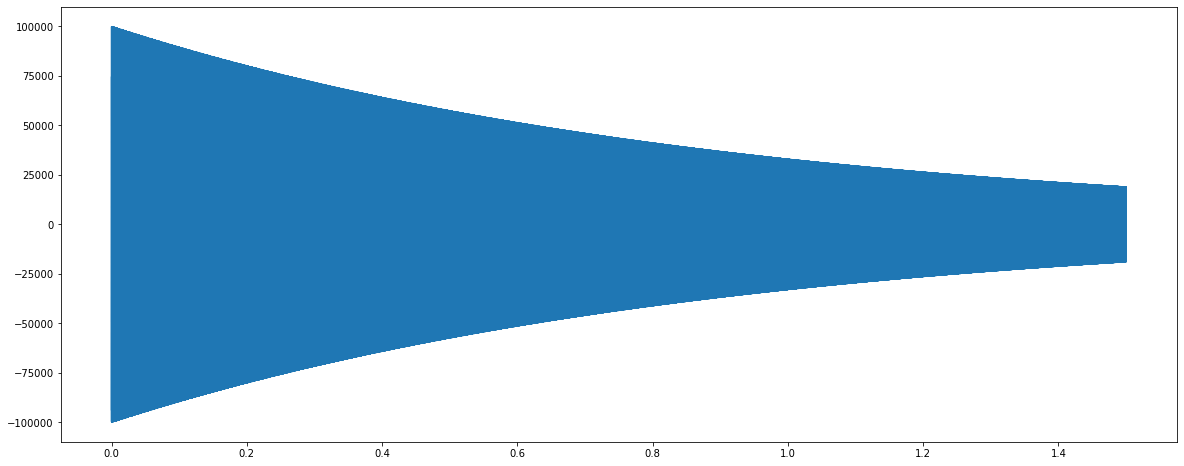

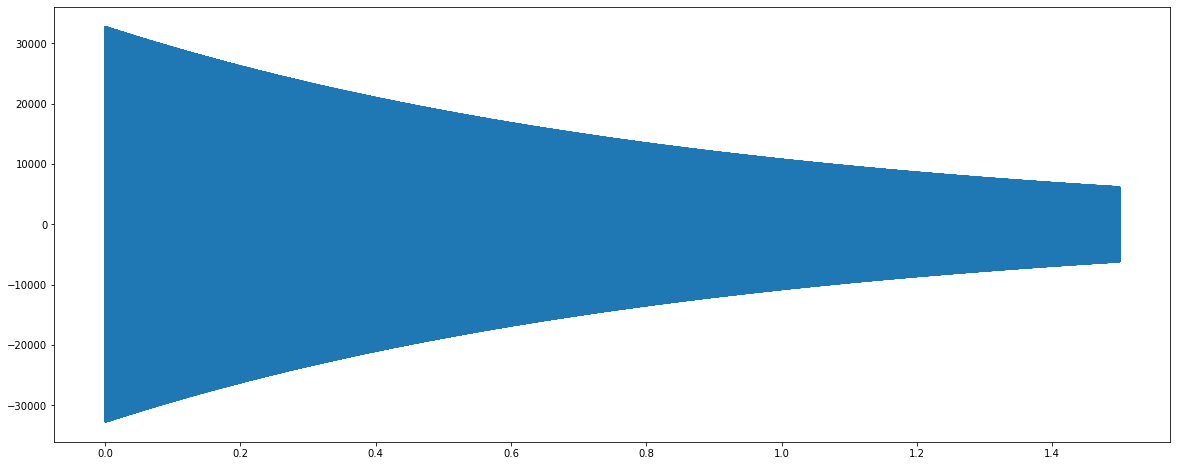

In [171]:
nustart = 20e3
signal_length = 1.5
nu_test = nustart + np.random.rand()*10
print(nu_test)
sampling_rate = 192000
t = np.arange(0.000, signal_length, 1/sampling_rate)
 # A0, tau (dampening), nuz, phase, chirp (Hz/s)
p0 = [1e5, 0.9, nu_test, 42, 0]
signal = ringdown_func(t, *p0)
#plt.plot(t[:192], signal[:192])
plt.plot(t, signal)
plt.show()
# only 15 bit measurement depth:
signal = np.int16((signal / signal.max()) * 32767)
plt.plot(t, signal)
plt.show()

In [172]:
popt, perr, results =  fitringdown(t, signal, nustart, chirp=True, bandpass=False, bpspan=10000, nuz_span=100)


 # A0, tau (dampening), nuz, phase, chirp (Hz/s)
p0	 [100000.0, 0.9, 20006.346761314653, 42, 0]
popt	 [3.280161240562e+04 8.999645392624e-01 2.000634676129e+04
 4.200000295518e+01 3.378089968238e-08]
perr	 [2.729252910678e-03 1.292611033619e-07 7.892052371722e-08
 6.428162661765e-06 6.437835001611e-08]
pdiff	 [ 6.719838759438e+04  3.546073756522e-05  2.818705979735e-08
 -2.955179525088e-06 -3.378089968238e-08]
preldiff	 [ 2.048630621063e+00  3.940237200266e-05  1.408905890399e-12
 -7.036141231328e-08 -1.000000000000e+00]


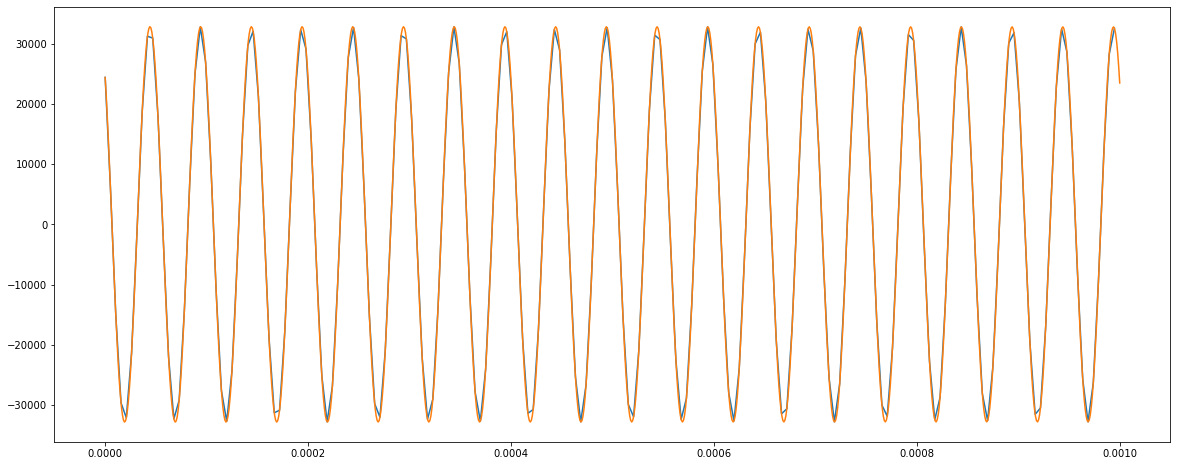

In [173]:
print(" # A0, tau (dampening), nuz, phase, chirp (Hz/s)")
print("p0\t", p0)
print("popt\t", popt)
print("perr\t", perr)
#print("pdiff\t", p0[:-1]-popt) # chirp ignored in fit
print("pdiff\t", p0-popt)
#print("preldiff\t", (p0[:-1]-popt)/popt)
print("preldiff\t", (p0-popt)/popt)

tfit = np.arange(0, 0.001, 1e-6)
plt.plot(t[:192], signal[:192])
plt.plot(tfit, ringdown_func(tfit, *popt))
plt.show()

## add noise

-41095.329572312876 44554.07969449348


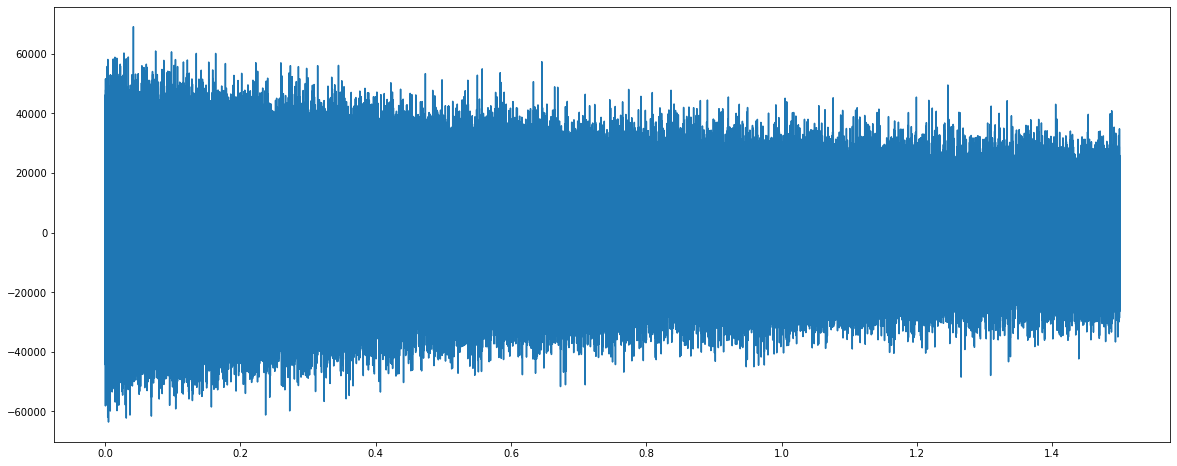

In [177]:
noise_amp = 1e3
noise = at.noise.white(num_points=len(signal), b0=noise_amp, fs=sampling_rate)
print(min(noise), max(noise))
nsignal = signal + noise
#plt.plot(t[:192], nsignal[:192])
plt.plot(t, nsignal)
plt.show()


In [178]:
popt, perr, results =  fitringdown(t, nsignal, nustart, chirp=True, bandpass=False, bpspan=10000, nuz_span=20)


 # A0, tau (dampening), nuz, phase, chirp (Hz/s)
p0	 [100000.0, 0.9, 20006.346761314653, 42, 0]
popt	 [3.274661973994e+04 9.000650471912e-01 2.000634382153e+04
 4.226033444195e+01 1.508656619826e-03]
perr	 [7.341903634407e+01 3.483627578340e-03 2.128292296669e-03
 1.732954946131e-01 1.736246196156e-03]
pdiff	 [ 6.725338026006e+04 -6.504719117362e-05  2.939788526419e-03
 -2.603344419451e-01 -1.508656619826e-03]
preldiff	 [ 2.053750304434e+00 -7.226943361106e-05  1.469428173705e-07
 -6.160255127718e-03 -1.000000000000e+00]


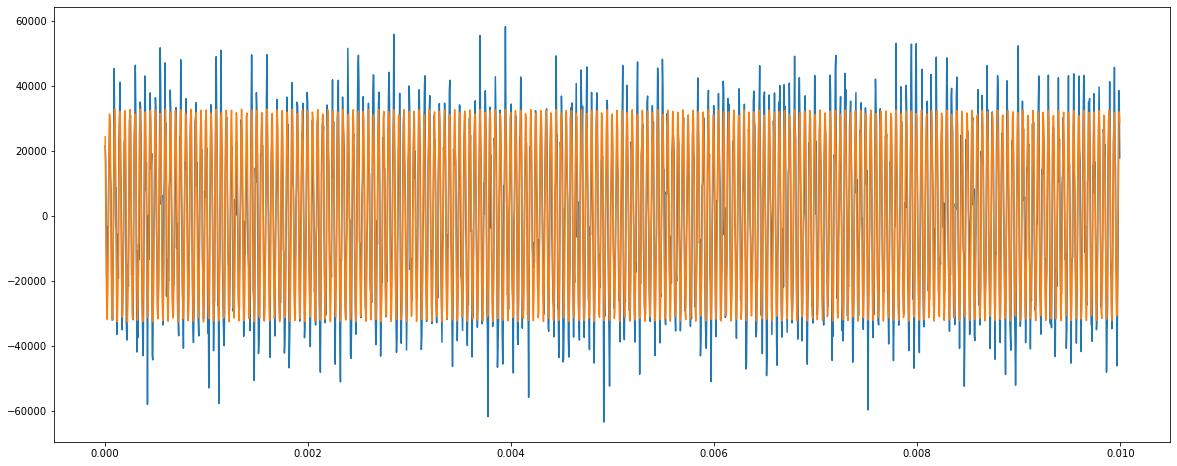

In [179]:
print(" # A0, tau (dampening), nuz, phase, chirp (Hz/s)")
print("p0\t", p0)
print("popt\t", popt)
print("perr\t", perr)
#print("pdiff\t", p0[:-1]-popt) # chirp ignored in fit
print("pdiff\t", p0-popt)
#print("preldiff\t", (p0[:-1]-popt)/popt)
print("preldiff\t", (p0-popt)/popt)

tfit = np.arange(0, 0.001, 1e-6)
#plt.plot(t, nsignal)
plt.plot(t[:1920], nsignal[:1920])
plt.plot(t[:1920], ringdown_func(t[:1920], *popt))
plt.show()

0.0006359616679848032


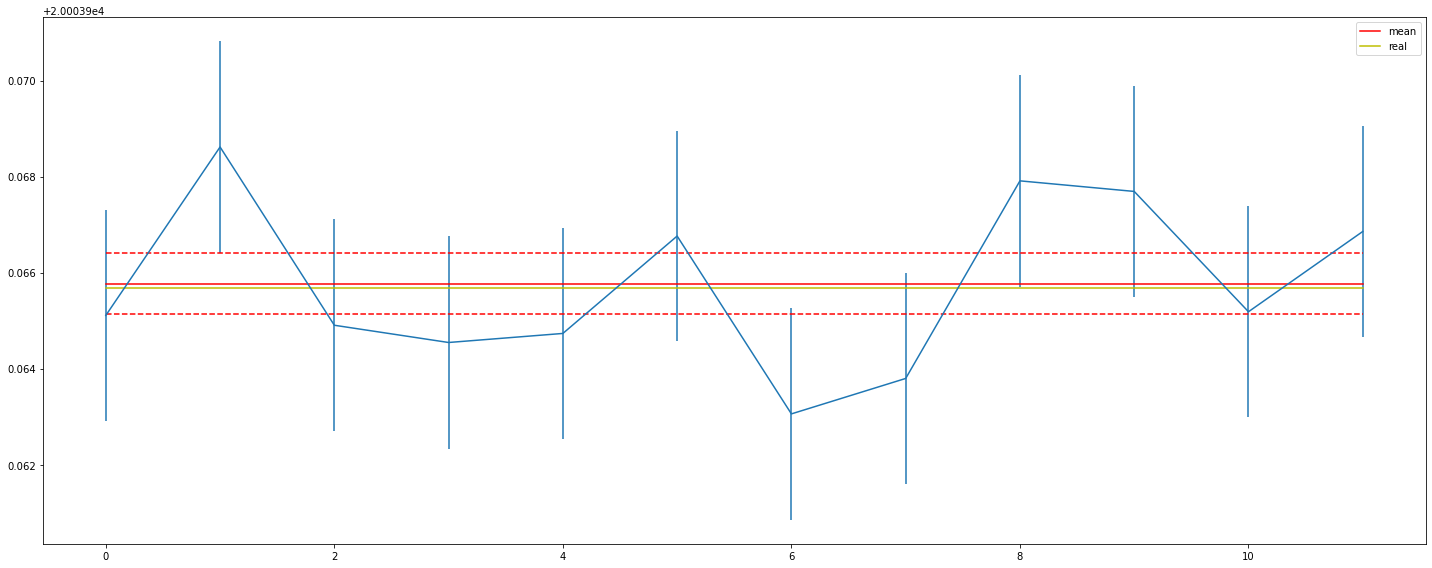

0.05313230966559047


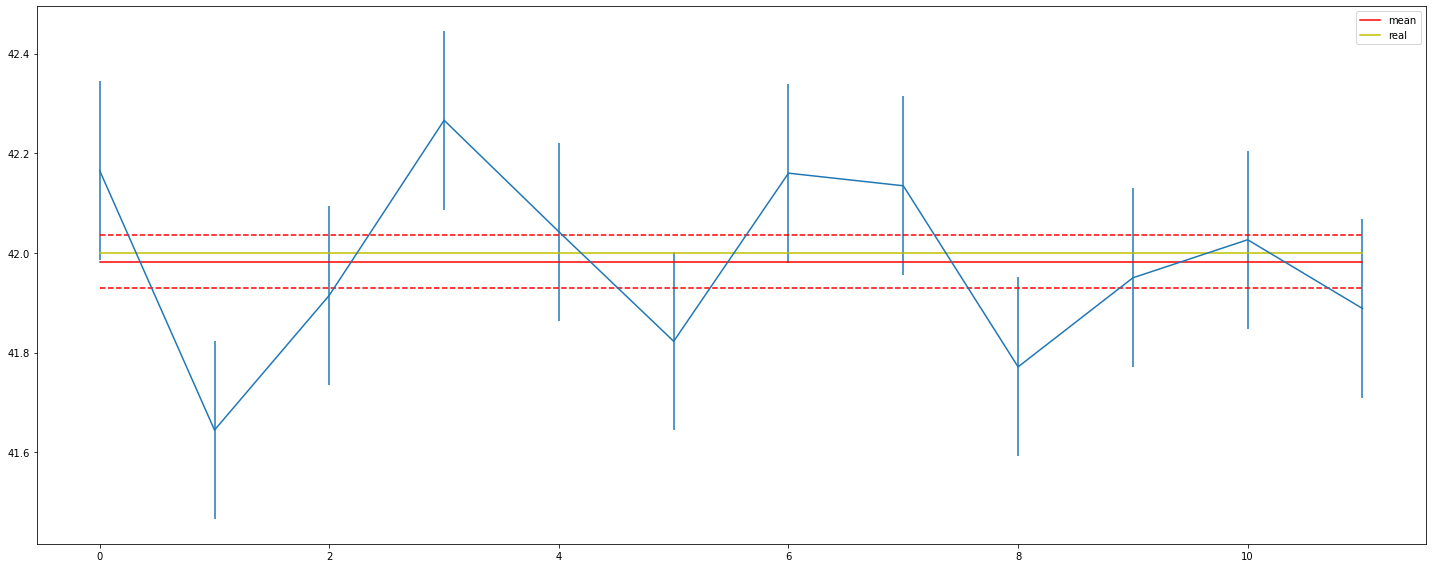

In [163]:
fits = []
dfits = []
phases = []
dphases = []
num = 12
for i in range(num):
    noise = at.noise.white(num_points=len(signal), b0=noise_amp, fs=sampling_rate)
    nsignal = signal + noise
    popt, perr, results =  fitringdown(t, nsignal, nustart, chirp=True, bandpass=False, bpspan=500, nuz_span=20)
    fits.append(popt[2])
    dfits.append(perr[2])
    phases.append(popt[3])
    dphases.append(perr[3])

plt.errorbar(range(num), fits, yerr=dfits)
mean, dmean = statistics.mean_and_error(fits, dfits)
print(dmean)
plt.plot(range(num), [mean]*num, 'r-', label='mean')
plt.plot(range(num), [mean+dmean]*num, 'r--', label='')
plt.plot(range(num), [mean-dmean]*num, 'r--', label='')
plt.plot(range(num), [p0[2]]*num, 'y-', label='real')
plt.legend()
plt.tight_layout()
plt.show()

plt.errorbar(range(num), phases, yerr=dphases)
mean, dmean = statistics.mean_and_error(phases, dphases)
print(dmean)
plt.plot(range(num), [mean]*num, 'r-', label='mean')
plt.plot(range(num), [mean+dmean]*num, 'r--', label='')
plt.plot(range(num), [mean-dmean]*num, 'r--', label='')
plt.plot(range(num), [p0[3]]*num, 'y-', label='real')
plt.legend()
plt.tight_layout()
plt.show()

## now with bandpass filter

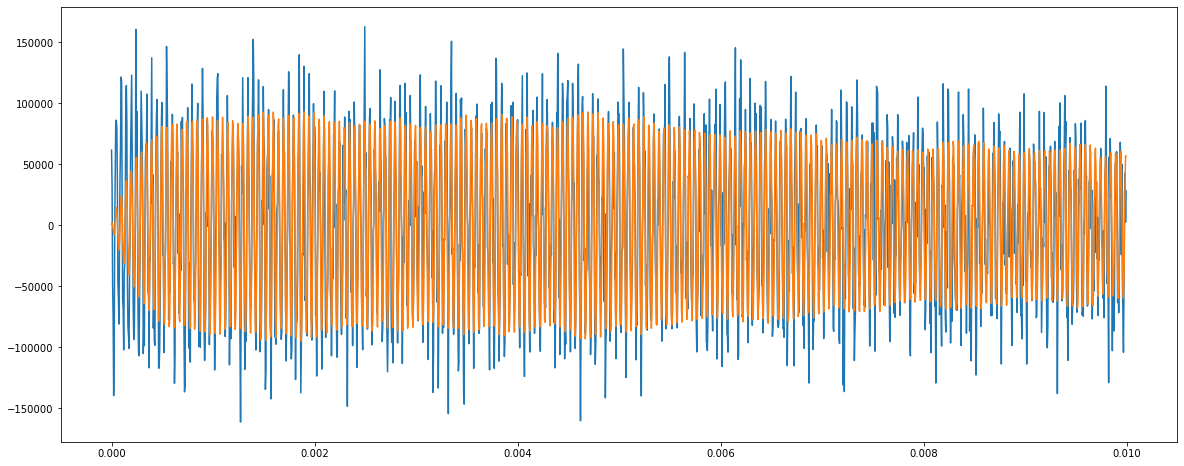

In [141]:
noise = at.noise.white(num_points=len(signal), b0=10000.0, fs=sampling_rate)
nsignal = signal + noise
bpspan = 1000
fnsignal = butter_bandpass_filter(nsignal, nu_test-int(bpspan/2), nu_test+int(bpspan/2), sampling_rate, order=1)
plt.plot(t[:1920], nsignal[:1920])
plt.plot(t[:1920], fnsignal[:1920])
plt.show()

0.11453707413836181


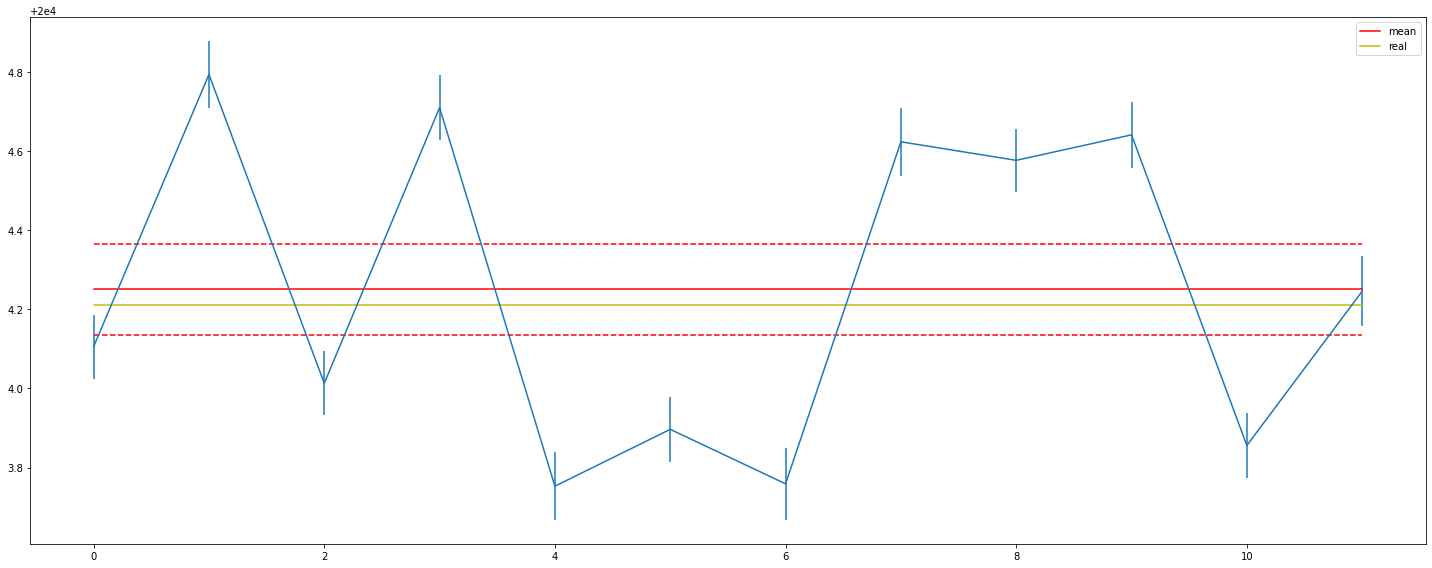

In [142]:
fits = []
dfits = []
num = 12
for i in range(num):
    noise = at.noise.white(num_points=len(signal), b0=10000.0, fs=sampling_rate)
    nsignal = signal + noise
    popt, perr, results =  fitringdown(t, nsignal, nustart, chirp=True, bandpass=True, bpspan=1000, nuz_span=20)
    fits.append(popt[2])
    dfits.append(perr[2])

plt.errorbar(range(num), fits, yerr=dfits)
mean, dmean = statistics.mean_and_error(fits, dfits)
print(dmean)
plt.plot(range(num), [mean]*num, 'r-', label='mean')
plt.plot(range(num), [mean+dmean]*num, 'r--', label='')
plt.plot(range(num), [mean-dmean]*num, 'r--', label='')
plt.plot(range(num), [p0[2]]*num, 'y-', label='real')
plt.legend()
plt.tight_layout()
plt.show()

# NOW real data

23689.320000000007
0.21968035904501448
23689.100319640962 0.10022057010274253


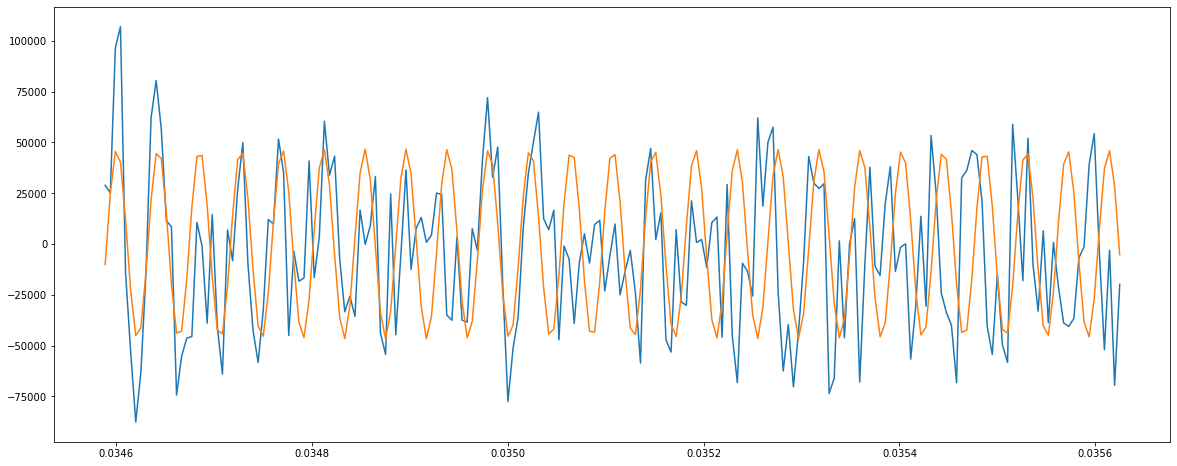

In [21]:
x, y = getdata(anadata["fname"].iloc[2])
x, y = cut(x,y,0.02,0.5)

nuz = 501553.9 - 475000 # 724000
nuz = 498689.32 - 475000 # 724000

popt, perr, results = fitringdown(x,y,nuz,chirp=False,bandpass=False,bpspan=10000, nuz_span=10)

print(nuz)
print(nuz-popt[2])
print(popt[2], perr[2])
#print(popt, perr)

pstart = 2800
pend = pstart + 200
plt.plot(x[pstart:pend], y[pstart:pend])
#plt.plot(x, 1e5*np.cos(x*5e6*2*np.pi))
xsym = np.arange(x.min(), x.max(), 1e-6)
#plt.plot(xsym, ringdown_func(xsym, *p0))
plt.plot(x[pstart:pend], ringdown_func(x[pstart:pend], *popt))
plt.show()



0.05 9600 23689.320000000007 23691.160098883734 1.840098883727478
0.1 19199 23689.320000000007 23690.40854117027 1.0885411702620331
0.15000000000000002 28800 23689.320000000007 23689.224331116755 -0.09566888325207401
0.2 38400 23689.320000000007 23688.93010341548 -0.38989658452555886
0.25 47999 23689.320000000007 23688.997622278457 -0.3223777215498558
0.30000000000000004 57600 23689.320000000007 23689.282823774316 -0.03717622569092782
0.35000000000000003 67200 23689.320000000007 23689.349730152746 0.02973015273892088
0.4 76800 23689.320000000007 23689.37265469231 0.052654692302894546
0.45 86400 23689.320000000007 23689.386326345535 0.06632634552806849
0.5 95999 23689.320000000007 23689.36259817485 0.042598174841259606
0.55 105600 23689.320000000007 23689.362679544673 0.042679544665588764
0.6000000000000001 115200 23689.320000000007 23689.36555193303 0.04555193302439875
0.65 124799 23689.320000000007 23689.36174674113 0.0417467411243706
0.7000000000000001 134400 23689.320000000007 23689

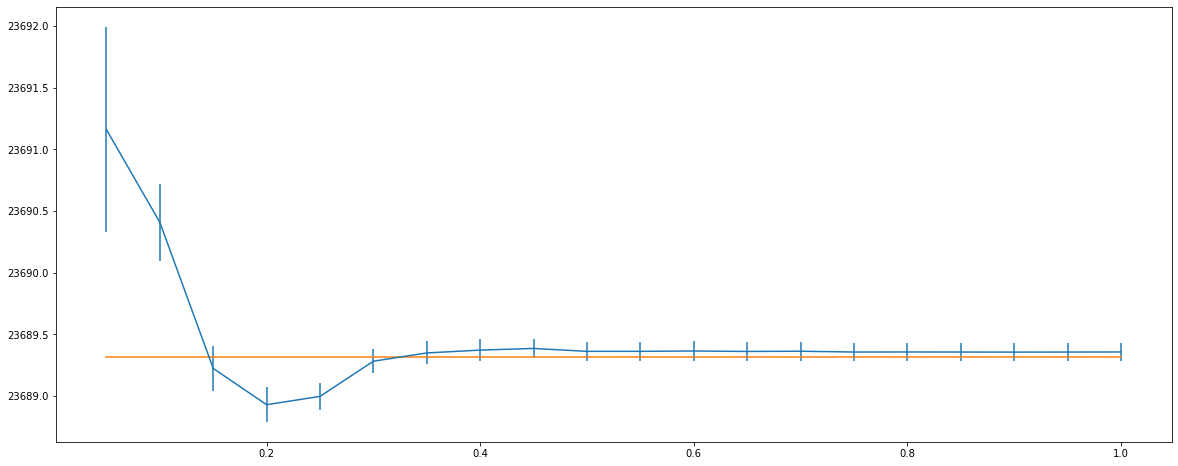

In [22]:
li = []
dli = []
num = 20
start = 0.01
step = 0.05
last = None
lesser = 0
times = []
for i in range(num):
    x, y = getdata(anadata["fname"].iloc[2])
    #y = butter_bandpass_filter(y, nuz-int(1000/2), nuz+int(1000/2), sampling_rate, order=1)
    length = step*(i+1)
    x, y = cut(x,y, start, length)
    if last is not None and np.array_equal(y, last):
        lesser += 1
        print(i, "is not different from", i-1)
        continue
    last = y

    popt, perr, fitres = fitringdown(x,y, nuz, chirp=False, bandpass=False, bpspan=1000, nuz_span=10)
    print(length, len(y), nuz, popt[2], popt[2]-nuz)
    li.append(popt)
    dli.append(perr)
    times.append(length)

num -= lesser
li = np.asarray(li)
dli = np.asarray(dli)
pprint(li[:,2])
pprint(dli[:,2])

#plt.errorbar(range(num), li[:,2]-min(li[:,2]), yerr=dli[:,2])
plt.errorbar(times, li[:,2], yerr=dli[:,2])
plt.plot(times, [nuz]*num)
plt.show()


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning:

overflow encountered in exp



[  2.204423789125 -21.649423171616   0.082139064274]
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35
 1.4  1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95] [2.286562853399 0.828903863459 0.335111141627 0.167835219194
 0.111169268101 0.091973259694 0.085470470424 0.08326760265
 0.082521364963 0.082268571449 0.082182935783 0.082153926071
 0.082144098817 0.082140769762 0.08213964202  0.08213925999
 0.082139130574 0.082139086733 0.082139071882 0.082139066851
 0.082139065147 0.082139064569 0.082139064374 0.082139064307
 0.082139064285 0.082139064277 0.082139064275 0.082139064274
 0.082139064274 0.082139064274 0.082139064274 0.082139064274
 0.082139064274 0.082139064274 0.082139064274 0.082139064274
 0.082139064274 0.082139064274 0.082139064274 0.082139064274]
[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.  ] [0.828903863459 0.335111141627 0

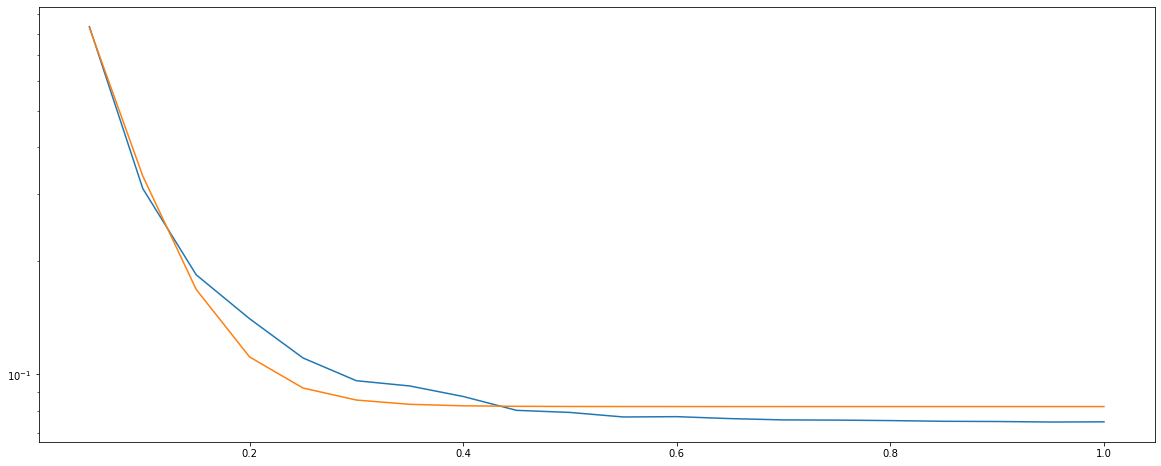

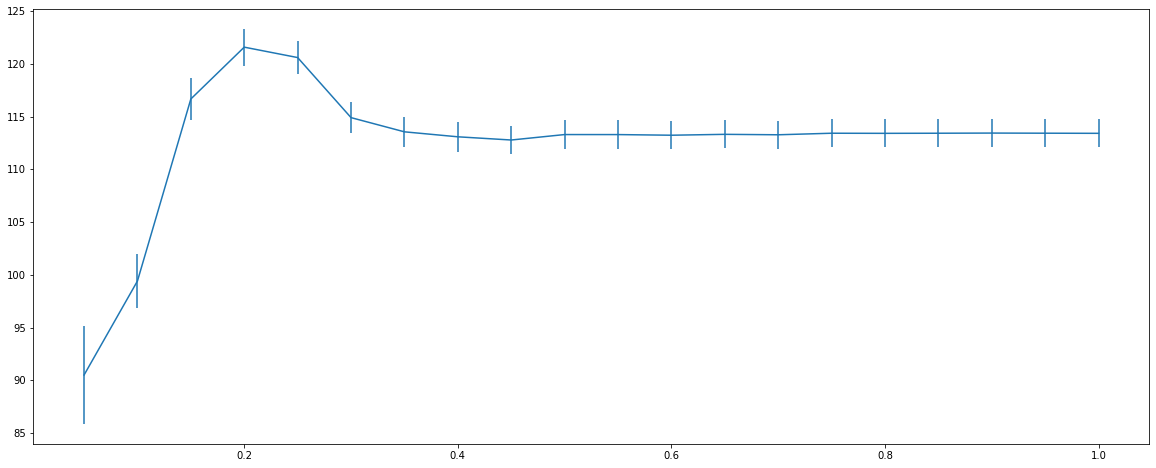

In [23]:

times = np.asarray(times)
def expo(t, a, b, c):
    return a*np.exp(b*t) + c
p0 = [100, -200, 1e-5]
popt, pcov = curve_fit(expo, times, dli[:,2], p0=p0)
print(popt)
perr = np.sqrt(np.diag(pcov))
long_times = np.arange(0.0, 2, 0.05)
print(long_times, expo(long_times, *popt))
print(times, expo(times, *popt))

#plt.plot(range(num), dli[:,2])
plt.plot(times, dli[:,2], label="data")
plt.plot(times, expo(times, *popt), label="expo fit")
plt.yscale("log")
#plt.ylim((1e-2, None))
plt.show()

#plt.errorbar(range(num), li[:,3]*360, yerr=dli[:,3]*360)
plt.errorbar(times, li[:,3], yerr=dli[:,3])
plt.show()

23689.320000000007
array([23689.408443185293, 23689.36360697709 , 23689.110040384938,
       23676.594539190537, 23649.310031382807, 23739.028066979685])
array([6.324474158937e-02, 7.571894982943e-02, 9.744776214006e-02,
       1.387571586902e+00, 5.243747450417e+85, 0.000000000000e+00])


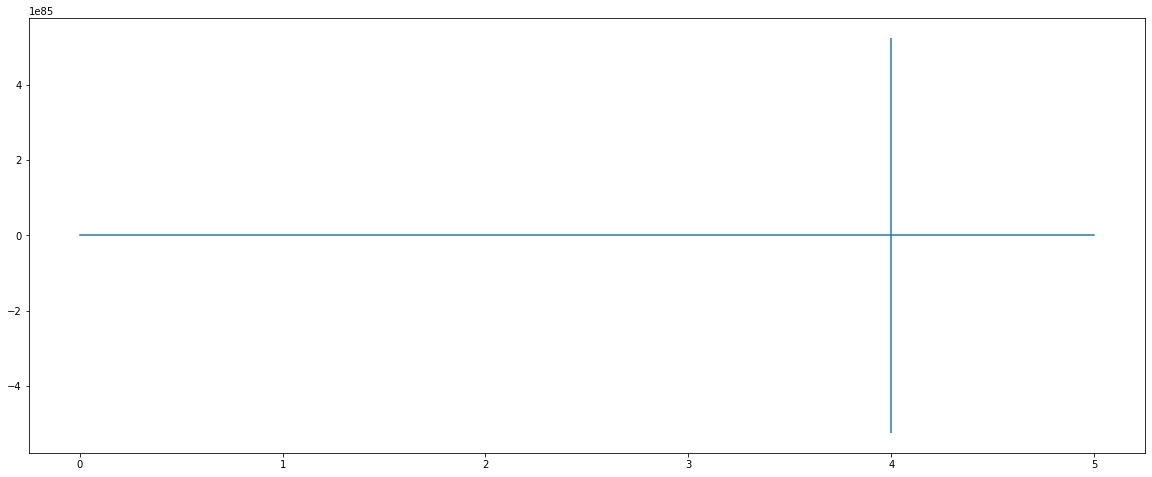

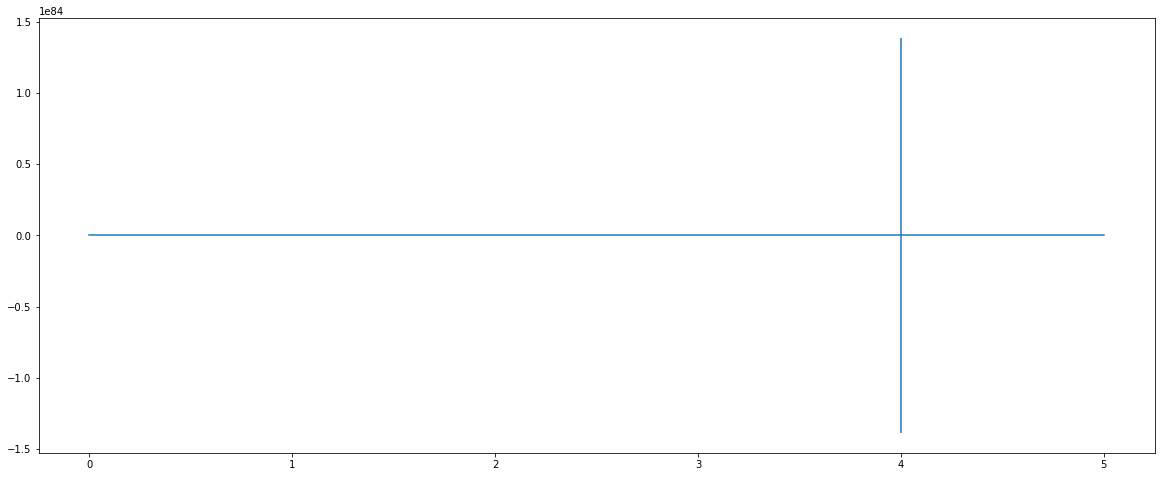

In [24]:
li = []
dli = []
for i in range(6):
    x, y = getdata(anadata["fname"].iloc[2])
    x, y = cut(x,y,0.01*(i),0.7)
    popt, perr, fitres = fitringdown(x,y,nuz,bandpass=False,bpspan=1000)
    li.append(popt)
    dli.append(perr)

li = np.asarray(li)
dli = np.asarray(dli)
print(nuz)
pprint(li[:,2])
pprint(dli[:,2])

plt.errorbar(range(6), li[:,2], yerr=dli[:,2])
plt.show()

plt.errorbar(range(6), li[:,3], yerr=dli[:,3])
plt.show()

array([23674.422266524343, 23689.357486565925, 23671.785710292883,
       23689.58554331968 , 23680.933574662948, 23689.915615070113,
       23679.5065478677  , 23689.78401719667 , 23685.562980923427,
       23689.613801551768, 23698.894222746218, 23670.848572870607,
       23726.742818756986, 23648.930701471647, 23697.55237069893 ,
       23639.84916421771 , 23639.32000065239 , 23680.00562275537 ,
       23639.58608053521 ])
array([-1.489773347566e+01,  3.748656591779e-02, -1.753428970712e+01,
        2.655433196742e-01, -8.386425337059e+00,  5.956150701059e-01,
       -9.813452132308e+00,  4.640171966639e-01, -3.757019076580e+00,
        2.938015517611e-01,  9.574222746211e+00, -1.847142712940e+01,
        3.742281875698e+01, -4.038929852836e+01,  8.232370698923e+00,
       -4.947083578230e+01, -4.999999934762e+01, -9.314377244638e+00,
       -4.973391946480e+01])
array([2.217120335341e+00, 7.482305703559e-02, 1.272192347812e+00,
       7.377558345400e-02, 7.153585003857e-01, 9.81743

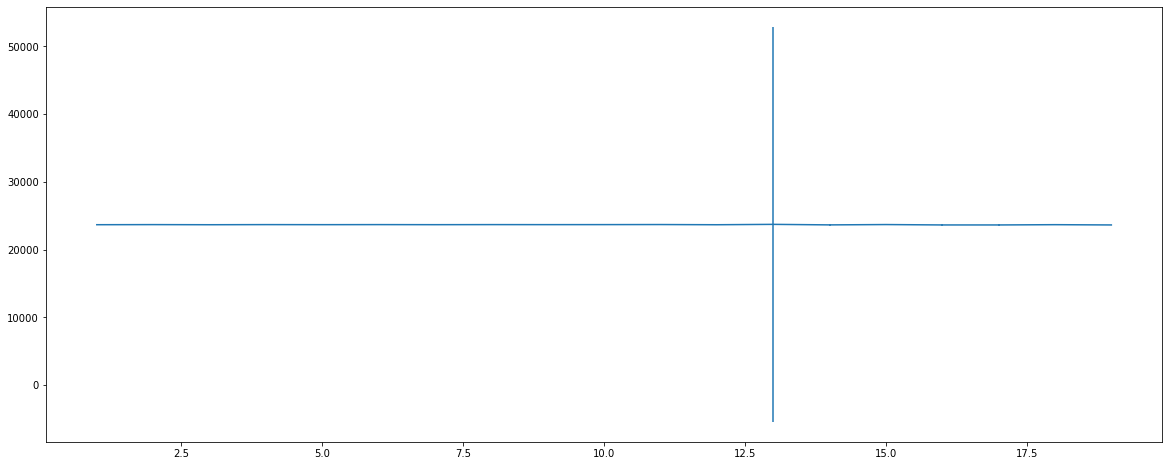

nuz (nan, 0.0)


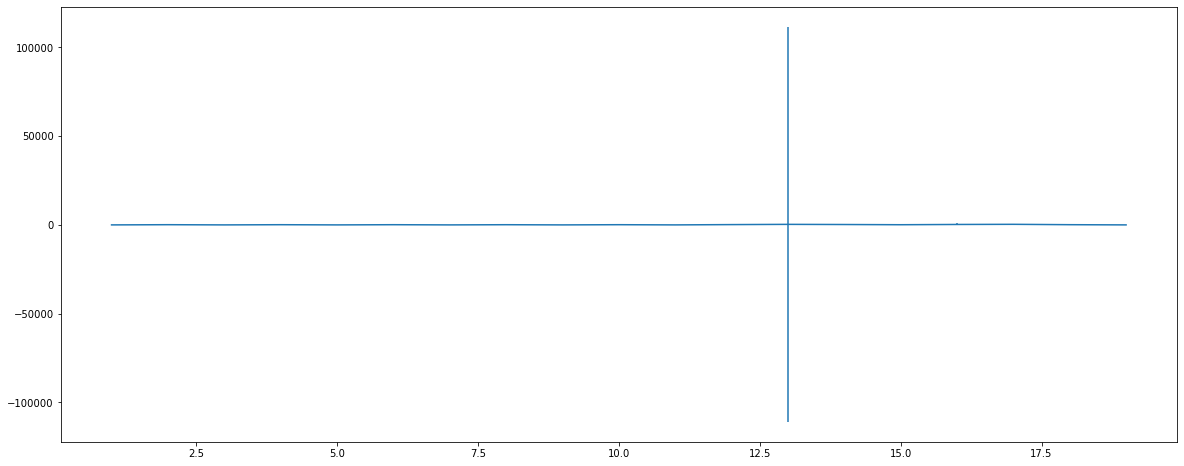

In [25]:
li = []
dli = []
num = 20
ana1data = anadata[anadata["ch"] == "1"]
for i in range(1,num):
    x, y = getdata(ana1data["fname"].iloc[i])
    x, y = cut(x,y,0.01,1.0)

    popt, perr, fitres = fitringdown(x,y, nuz, chirp=False, bandpass=False, bpspan=1000, nuz_span=100)
    li.append(popt)
    dli.append(perr)

li = np.asarray(li)
dli = np.asarray(dli)
pprint(li[:,2])
pprint(li[:,2]-nuz)
pprint(dli[:,2])

plt.errorbar(range(1, num), li[:,2], yerr=dli[:,2])
plt.show()

print("nuz", statistics.mean_and_error(li[:,2], dli[:,2]))

plt.errorbar(range(1, num), li[:,3], yerr=dli[:,3])
plt.show()

In [26]:
nuz = 501554.2 - 475000 # 724000
#nuz = 498689.32 - 475000 # 724000
print(nuz)

26554.20000000001


In [27]:
rdfit_res = pd.DataFrame(columns=["dtime_rd", "nu_z_rd", "dnu_z_rd", "phi_rd", "dphi_rd", "tau_rd", "dtau_rd", "A_rd", "dA_rd"])

grouping = [0, 0, 0, 0, 0, 0]
trap = 3
ch = "1"


nu_z_config = meas_config['position_1']['configuration']['traps'][trap]['nu_z']
LO_config = meas_config['position_1']['configuration']['traps'][trap]['LO']
nu_guess = nu_z_config - LO_config
anachdata = anadata[anadata['ch']==ch]

length = len(anachdata)
print(length)
counter = -12
for i, row in anachdata.iterrows():
    #print(i)
    counter += 1
    if counter == 12:
        counter = -12
    if counter <= 0:
        continue
    dtime = row["dtime"]
    perc = int(i/length*1000)/10
    if perc%10 == 0:
        print(i, "\t", perc, "% \t", dtime)
    x, y = getdata(row["fname"])
    x, y = cut(x,y,0.01,0.8)
    try:
        popt, perr, fitres = fitringdown(x, y, nuz, chirp=False,bandpass=False,bpspan=4000, nuz_span=10)
        print(i, counter, fitres["nu"], fitres["dnu"], fitres["phi"], fitres["dphi"])
        ser = pd.Series(data=[dtime, fitres["nu"]+LO_config, fitres["dnu"], fitres["phi"], fitres["dphi"], fitres["tau"], fitres["dtau"], fitres["A"], fitres["dA"]], index=rdfit_res.columns)
        rdfit_res = rdfit_res.append(ser, ignore_index=True)
    except:
        pass

893
12 1 26556.424234016307 0.23077603364904675 117.43124113736957 1.576028879696809
13 2 26549.282457209978 0.0 0.028349920717030686 0.0
14 3 26558.4222379919 0.18780285025603505 97.56889105347143 1.3775758353652154
15 4 26559.197100287478 0.0 359.34671949252515 0.0
16 5 26559.199999998695 0.2083484116908269 101.95889850580875 1.494891584071906
17 6 26549.234438064897 0.0 0.00497600715894253 0.0
18 7 26555.932000336532 0.1590873697808996 120.19847923938387 1.2604507597644445
19 8 26549.264740793278 0.0 359.1717482686477 0.0
20 9 26554.925852187418 0.18717776006232467 128.79478438944807 1.4159907587250167
21 10 26557.61338347856 0.18053881349811163 126.43018244201852 1.3485765351080201
22 11 26558.98322318606 0.18420482050153902 101.04179512041937 1.3657274725297934
36 1 26559.200000000008 0.1811399621342903 101.23101119726905 1.374320314340404
37 2 26556.737942060015 0.18739657662228748 101.70302547697887 1.383287492616443
38 3 26559.200000000008 0.15001542674614862 97.49577075631221 

234 7 26559.200000000008 0.15532821554267448 93.35915539059931 1.2444106704332856
235 8 26559.200000000008 0.18712237412526656 53.080426541890894 1.3907849763111295
236 9 26559.199999999604 0.12903548258689285 95.87871415343588 1.1189522067753297
237 10 26558.891247844167 0.1980630765465358 10.560844176437152 1.4411400370927927
238 11 26558.961770277718 0.18378796389313817 102.50581306695729 1.387286227162036
252 1 26559.200000000008 0.14065512793548682 76.03694652861466 1.1769410077721416
253 2 26556.776082573557 0.1814879852599939 1.381758094784655e-12 1.3600522206384869
254 3 26558.01212051157 0.14691355990633487 101.57030780152927 1.201840146401695
255 4 26554.969294080835 0.17530644288830569 6.789616657255879e-18 1.3440307178906654
256 5 26559.200000000008 0.18163881924717862 98.61188196052962 1.3977926999588188
257 6 26558.344177424682 0.1593422856810203 2.645483065248534e-16 1.2601385105663574
258 7 26549.200695071722 32.25325938413952 1.3114920774838181e-05 91.15042454440173
25

469 2 26556.434986609205 0.1843012414669284 24.470699392568633 1.3734115778125418
470 3 26559.199999995504 0.1711428646496069 95.07148757305904 1.3298703711216822
471 4 26558.709767787055 0.15975270093762814 1.993822574284992e-07 1.2667745147485912
472 5 26559.200000000008 0.13009488755485266 86.43170654148388 1.118860472929655
473 6 26558.776048757798 0.1667445806367702 1.837955326422442e-16 1.2915257685037502
474 7 26549.200000000015 0.0 3.450454617853693e-17 0.0
475 8 26558.838854321377 0.16051051210626247 11.76733651601587 1.250089727040636
476 9 26557.998197776866 0.17065107246729033 106.51473267123443 1.3137341336743296
477 10 26556.943828515487 0.15043233135329023 8.361924570515222e-17 1.2121239203408785
492 1 26557.915814123742 0.1547005536937288 98.71470206544045 1.2359853565088543
493 2 26551.420574096395 0.1926678633543425 1.4675081003406713e-19 1.423834121950175
494 3 26559.003296545532 0.17190629378167943 93.76588966229802 1.3322384726868297
495 4 26554.040600671167 0.2211

693 10 26549.224970046325 0.0 0.0033837601486629842 0.0
694 11 26559.200000000008 0.1876648445113471 95.04942699189048 1.3792686833842709
708 1 26555.053949910893 181.72102793943273 24.16480960072288 497.9907774238291
709 2 26549.200428275537 0.0 8.735688650687422e-07 0.0
710 3 26549.202177339965 2547.4484589461576 3.380927429623956e-06 7235.600430179671
711 4 26555.814331158217 204.56027480218782 62.57363240938591 633.5495477913163
712 5 26549.20064313372 0.0 358.2001497237982 0.0
713 6 26559.199989753648 707.9396146633959 49.50592970440853 1973.093576008786
714 7 26554.49357174863 230.33831604034197 0.002398885326949325 606.140113319204
715 	 80.0 % 	 2022-01-26 07:01:27
715 8 26549.200000031196 1161.9019029799972 2.284614257766596e-13 3284.538760444499
716 9 26549.200030138945 5328.42074394253 6.258478445675853e-07 15823.154676883643
717 10 26549.200000000015 330.35135882044324 148.60947651404473 910.9448139964617
718 11 26549.20000000241 0.0 1.4161609885455976e-11 0.0
732 1 26556.1

In [28]:
display(rdfit_res)
rdfit_res_backup = rdfit_res.copy()

dtime_rd     nu_z_rd  dnu_z_rd   phi_rd  dphi_rd  tau_rd  \
0   2022-01-25 19:01:19  501556.424     0.231  117.431    1.576   0.035   
1   2022-01-25 19:02:42  501549.282     0.000    0.028    0.000   0.000   
2   2022-01-25 19:02:54  501558.422     0.188   97.569    1.378   0.039   
3   2022-01-25 19:04:18  501559.197     0.000  359.347    0.000   0.000   
4   2022-01-25 19:04:30  501559.200     0.208  101.959    1.495   0.038   
..                  ...         ...       ...      ...      ...     ...   
394 2022-01-26 09:42:45  501559.200     0.148   91.263    1.217   0.046   
395 2022-01-26 09:44:09  501549.222     0.000    0.003    0.000   0.000   
396 2022-01-26 09:44:21  501559.053     0.172   94.654    1.315   0.041   
397 2022-01-26 09:45:45  501549.206     0.000    0.001    0.000   0.000   
398 2022-01-26 09:45:57  501558.036     0.159   99.963    1.265   0.044   

     dtau_rd        A_rd     dA_rd  
0      0.001  150000.000  2603.602  
1      0.000   50442.202     0.000  
2      0.001  150000.000  2324.668  
3      0.000   52857.760     0.000  
4      0.001  150000.000  2505.639  
..       ...         ...       ...  
394    0.001  150000.000  2115.238  
395    0.000   50536.337     0.000  
396    0.001  150000.000  2244.984  
397    0.000   50572.755     0.000  
398    0.001  150000.000  2182.752  

[399 rows x 9 columns]

In [29]:
nu_p_phases = data["phase_data"]
axial_data = data["axial_data"]
axial_data["time"] += timedelta(seconds=0)
nu_p_phases["time"] += timedelta(seconds=80)

nu_p_phases["time_p"] = nu_p_phases["time"].to_numpy()


axial_data = filtering.minmax_value(axial_data, val="nu_z", min_val=300e3, max_val=1e6)
axial_data = axial_data[axial_data["masked"]==False]
axial_data["time_a"] = axial_data["time"].to_numpy()

t2axial = axial_data[axial_data["trap"] == trap]
t2axial = t2axial.set_index('time', drop=False)
print(t2axial.time_a.dtype)
t2phases = nu_p_phases[nu_p_phases["trap"] == trap]
t2phases = t2phases.set_index('time', drop=False)

t2axial.sort_index(inplace=True)
t2phases.sort_index(inplace=True)

for grpname, grp in t2axial.groupby("position"):
    print(grpname, grp.nu_res.mean(), grp.nu_z.mean(), grp.nu_res.mean() - grp.nu_z.mean()) 

display(t2axial)
display(t2phases)

fig = px.scatter(t2axial, x="time", y="nu_z", error_y="dnu_z", color="position", hover_data=['mcycle', 'cycle', 'position'])
fig.update_yaxes(matches=None, showticklabels=True)
fig.show()

fig = px.scatter(t2phases, x="time", y="phase", color="position", hover_data=['acc_time', 'mcycle', 'cycle', 'position'])
fig.update_yaxes(matches=None, showticklabels=True)
fig.show()

datetime64[ns]
position_1 501547.658209501 501554.1919604722 -6.533750971197151
position_2 498740.9122571547 498689.6203431248 51.29191402992001


mcycle  cycle    position  trap  acc_time  \
time                                                                    
2022-01-25 18:53:14.114878       1      1  position_2     3    70.050   
2022-01-25 19:06:18.828705       1      1  position_1     3    70.050   
2022-01-25 19:18:44.753581       1      2  position_2     3    70.050   
2022-01-25 19:31:11.643192       1      2  position_1     3    70.050   
2022-01-25 19:43:38.597916       1      3  position_2     3    70.050   
...                            ...    ...         ...   ...       ...   
2022-01-26 08:56:59.946713       2      4  position_1     3    70.050   
2022-01-26 09:09:30.098749       2      5  position_2     3    70.050   
2022-01-26 09:22:00.431040       2      5  position_1     3    70.050   
2022-01-26 09:34:31.139709       2      6  position_2     3    70.050   
2022-01-26 09:45:25.111950       2      6  position_1     3    70.050   

                                                 time        nu_z  dnu_z  \
time                                                                       
2022-01-25 18:53:14.114878 2022-01-25 18:53:14.114878  498689.671  0.004   
2022-01-25 19:06:18.828705 2022-01-25 19:06:18.828705  501554.232  0.016   
2022-01-25 19:18:44.753581 2022-01-25 19:18:44.753581  498689.641  0.001   
2022-01-25 19:31:11.643192 2022-01-25 19:31:11.643192  501554.296  0.015   
2022-01-25 19:43:38.597916 2022-01-25 19:43:38.597916  498689.664  0.005   
...                                               ...         ...    ...   
2022-01-26 08:56:59.946713 2022-01-26 08:56:59.946713  501554.179  0.015   
2022-01-26 09:09:30.098749 2022-01-26 09:09:30.098749  498689.530  0.002   
2022-01-26 09:22:00.431040 2022-01-26 09:22:00.431040  501554.178  0.014   
2022-01-26 09:34:31.139709 2022-01-26 09:34:31.139709  498689.617  0.003   
2022-01-26 09:45:25.111950 2022-01-26 09:45:25.111950  501554.107  0.018   

                            dip_width  ddip_width  fit_err  fit_success  \
time                                                                      
2022-01-25 18:53:14.114878      1.481       0.037    0.973         True   
2022-01-25 19:06:18.828705     10.087       0.132    1.077         True   
2022-01-25 19:18:44.753581      2.206       0.060    1.750         True   
2022-01-25 19:31:11.643192      9.858       0.107    0.911         True   
2022-01-25 19:43:38.597916      1.444       0.036    0.947         True   
...                               ...         ...      ...          ...   
2022-01-26 08:56:59.946713      9.606       0.120    0.957         True   
2022-01-26 09:09:30.098749      2.288       0.063    1.996         True   
2022-01-26 09:22:00.431040      9.420       0.112    0.933         True   
2022-01-26 09:34:31.139709      2.222       0.061    1.841         True   
2022-01-26 09:45:25.111950      9.685       0.132    0.943         True   

                            average_idx      nu_res  dnu_res  masked  \
time                                                                   
2022-01-25 18:53:14.114878            0  498735.537   12.468   False   
2022-01-25 19:06:18.828705            0  501545.327    0.640   False   
2022-01-25 19:18:44.753581            0  498729.361   15.158   False   
2022-01-25 19:31:11.643192            0  501548.859    0.513   False   
2022-01-25 19:43:38.597916            0  498735.247   12.103   False   
...                                 ...         ...      ...     ...   
2022-01-26 08:56:59.946713            0  501545.411    0.786   False   
2022-01-26 09:09:30.098749            0  498672.225   18.005   False   
2022-01-26 09:22:00.431040            0  501547.521    0.687   False   
2022-01-26 09:34:31.139709            0  498723.602   14.714   False   
2022-01-26 09:45:25.111950            0  501548.391    0.682   False   

                            nu_distance  dnu_distance  \
time                                                    
2022-01-25 18:53:14.114878      -45.865        12.468   
2022-

mcycle  cycle    position  trap  acc_time  \
time                                                                    
2022-01-25 18:49:11.104017       1      1  position_2     3     0.100   
2022-01-25 18:50:35.435775       1      1  position_2     3    70.050   
2022-01-25 18:50:47.399325       1      1  position_2     3     0.100   
2022-01-25 18:52:11.112965       1      1  position_2     3    70.050   
2022-01-25 18:52:22.764431       1      1  position_2     3     0.100   
...                            ...    ...         ...   ...       ...   
2022-01-26 09:46:09.025095       2      6  position_1     3     0.100   
2022-01-26 09:47:33.047197       2      6  position_1     3    70.050   
2022-01-26 09:47:45.119205       2      6  position_1     3     0.100   
2022-01-26 09:49:09.048710       2      6  position_1     3    70.050   
2022-01-26 09:49:20.985158       2      6  position_1     3     0.100   

                                                 time  phase  average_idx  \
time                                                                        
2022-01-25 18:49:11.104017 2022-01-25 18:49:11.104017  4.478            0   
2022-01-25 18:50:35.435775 2022-01-25 18:50:35.435775  0.061            0   
2022-01-25 18:50:47.399325 2022-01-25 18:50:47.399325  4.402            0   
2022-01-25 18:52:11.112965 2022-01-25 18:52:11.112965  0.097            0   
2022-01-25 18:52:22.764431 2022-01-25 18:52:22.764431  4.390            0   
...                                               ...    ...          ...   
2022-01-26 09:46:09.025095 2022-01-26 09:46:09.025095  2.533            0   
2022-01-26 09:47:33.047197 2022-01-26 09:47:33.047197  4.232            0   
2022-01-26 09:47:45.119205 2022-01-26 09:47:45.119205  2.412            0   
2022-01-26 09:49:09.048710 2022-01-26 09:49:09.048710  4.349            0   
2022-01-26 09:49:20.985158 2022-01-26 09:49:20.985158  2.745            0   

                            masked                     time_p  
time                                                           
2022-01-25 18:49:11.104017   False 2022-01-25 18:49:11.104017  
2022-01-25 18:50:35.435775   False 2022-01-25 18:50:35.435775  
2022-01-25 18:50:47.399325   False 2022-01-25 18:50:47.399325  
2022-01-25 18:52:11.112965   False 2022-01-25 18:52:11.112965  
2022-01-25 18:52:22.764431   False 2022-01-25 18:52:22.764431  
...                            ...                        ...  
2022-01-26 09:46:09.025095   False 2022-01-26 09:46:09.025095  
2022-01-26 09:47:33.047197   False 2022-01-26 09:47:33.047197  
2022-01-26 09:47:45.119205   False 2022-01-26 09:47:45.119205  
2022-01-26 09:49:09.048710   False 2022-01-26 09:49:09.048710  
2022-01-26 09:49:20.985158   False 2022-01-26 09:49:20.985158  

[837 rows x 10 columns]

In [30]:
rdfit_res.set_index('dtime_rd', drop=False)
print(rdfit_res.dtime_rd.dtype, len(rdfit_res))
#rdfit_res = rdfit_res[rdfit_res["dtime_rd"] > t2axial.time_a.min()]
fig = px.scatter(rdfit_res, x="dtime_rd", y="nu_z_rd", error_y="dnu_z_rd")
fig.show()

rdfit_res["masked"] = False

rdfit_res = filtering.sigma_size(rdfit_res, err="dnu_z_rd")
rdfit_res_filtered = rdfit_res[rdfit_res["masked"] == False]
fig = px.scatter(rdfit_res_filtered, x="dtime_rd", y="nu_z_rd", error_y="dnu_z_rd")
fig.show()

rdfit_res_filtered = filtering.minmax_value(rdfit_res_filtered, val="nu_z_rd", min_val=501.553e3, max_val=1e6)
rdfit_res_filtered = rdfit_res_filtered[rdfit_res_filtered["masked"] == False]
fig = px.scatter(rdfit_res_filtered, x="dtime_rd", y="nu_z_rd", error_y="dnu_z_rd")
fig.show()

rdfit_res_filtered = filtering.three_sigma(rdfit_res_filtered, "nu_z_rd", err="dnu_z_rd", times_sigma=3, undrift_xcolumn=None, manual_std=None, show=False)
rdfit_res_filtered = rdfit_res_filtered[rdfit_res_filtered["masked"] == False]
fig = px.scatter(rdfit_res_filtered, x="dtime_rd", y="nu_z_rd", error_y="dnu_z_rd")
fig.show()





datetime64[ns] 399


filtered bigsigma dnu_z_rd 2


filtered min max nu_z_rd 108


filtered 3sigma nu_z_rd 3


In [31]:
fulldf = pd.DataFrame()


for i, row in rdfit_res_filtered.iterrows():
    dt = row["dtime_rd"]
    #print(t2axial.index.get_loc(dt, method='nearest'))
    a = t2axial.iloc[t2axial.index.get_loc(dt, method='nearest')]
    p = t2phases.iloc[t2phases.index.get_loc(dt, method='nearest')]
    if p["mcycle"] != a["mcycle"] or p["cycle"] != a["cycle"] or p["position"] != a["position"]:
        display(a)
        display(p)
        print("WRONG!", dt)
        continue
        
    a2 = a[["nu_z", "dnu_z", "time_a", "position", "cycle", "mcycle", "average_idx"]]
    p2 = p[["phase", "time_p", "acc_time"]]
    
    temp = p2.append(a2.append(row))
    fulldf = fulldf.append(temp, ignore_index=True)

display(fulldf)

A_rd  acc_time  average_idx  cycle        dA_rd  dnu_z  dnu_z_rd  \
0    150000.000     0.100        0.000  1.000     2603.602  0.016     0.231   
1    150000.000     0.100        0.000  1.000     2324.668  0.016     0.188   
2     52857.760     0.100        0.000  1.000        0.000  0.016     0.000   
3    150000.000     0.100        0.000  1.000     2505.639  0.016     0.208   
4    150000.000     0.100        0.000  1.000     2171.806  0.016     0.159   
..          ...       ...          ...    ...          ...    ...       ...   
281  149997.663    70.050        0.000  6.000  1245332.765  0.003   237.603   
282   50532.811    70.050        0.000  6.000   770788.088  0.003   480.370   
283  150000.000     0.100        0.000  6.000     2115.238  0.018     0.148   
284  150000.000    70.050        0.000  6.000     2244.984  0.018     0.172   
285  150000.000    70.050        0.000  6.000     2182.752  0.018     0.159   

      dphi_rd  dtau_rd            dtime_rd  masked  mcycle        nu_z  \
0       1.576    0.001 2022-01-25 19:01:19   0.000   1.000  501554.232   
1       1.378    0.001 2022-01-25 19:02:54   0.000   1.000  501554.232   
2       0.000    0.000 2022-01-25 19:04:18   0.000   1.000  501554.232   
3       1.495    0.001 2022-01-25 19:04:30   0.000   1.000  501554.232   
4       1.260    0.001 2022-01-25 19:06:06   0.000   1.000  501554.232   
..        ...      ...                 ...     ...     ...         ...   
281   652.703    0.005 2022-01-26 09:36:39   0.000   2.000  498689.617   
282  1264.335    0.012 2022-01-26 09:39:39   0.000   2.000  498689.617   
283     1.217    0.001 2022-01-26 09:42:45   0.000   2.000  501554.107   
284     1.315    0.001 2022-01-26 09:44:21   0.000   2.000  501554.107   
285     1.265    0.001 2022-01-26 09:45:57   0.000   2.000  501554.107   

        nu_z_rd  phase   phi_rd    position  tau_rd  \
0    501556.424  2.624  117.431  position_1   0.035   
1    501558.422  2.624   97.569  position_1   0.039   
2    501559.197  2.623  359.347  position_1   0.000   
3    501559.200  2.623  101.959  position_1   0.038   
4    501555.932  2.700  120.198  position_1   0.043   
..          ...    ...      ...         ...     ...   
281  501559.200  1.690   76.395  position_2   0.003   
282  501556.823  1.629   36.168  position_2   0.003   
283  501559.200  2.525   91.263  position_1   0.046   
284  501559.053  3.758   94.654  position_1   0.041   
285  501558.036  3.996   99.963  position_1   0.044   

                        time_a                     time_p  
0   2022-01-25 19:06:18.828705 2022-01-25 19:02:16.259287  
1   2022-01-25 19:06:18.828705 2022-01-25 19:02:16.259287  
2   2022-01-25 19:06:18.828705 2022-01-25 19:03:51.678970  
3   2022-01-25 19:06:18.828705 2022-01-25 19:03:51.678970  
4   2022-01-25 19:06:18.828705 2022-01-25 19:05:27.191586  
..                         ...                        ...  
281 2022-01-26 09:34:31.139709 2022-01-26 09:36:39.057558  
282 2022-01-26 09:34:31.139709 2022-01-26 09:39:50.936205  
283 2022-01-26 09:45:25.111950 2022-01-26 09:42:57.170792  
284 2022-01-26 09:45:25.111950 2022-01-26 09:44:21.155301  
285 2022-01-26 09:45:25.111950 2022-01-26 09:45:57.094086  

[286 rows x 20 columns]

In [32]:
fulldf["masked"] = False

avgdf = statistics.average_subsets(fulldf, groupby=["mcycle", "cycle", "position", "average_idx"], errortype="weighted", columns=["phase", "nu_z_rd", "time_p", "dtime_rd"], dcolumns=["dphase", "dnu_z_rd", None, None], masked=True)

display(avgdf)

fig = px.scatter(avgdf, x="dtime_rd", y="nu_z_rd", error_y="dnu_z_rd")
fig.show()

C:\Users\door\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:262: RuntimeWarning:

Degrees of freedom <= 0 for slice



A_rd  acc_time  average_idx   cycle        dA_rd  dnu_z  dnu_z_rd  \
0   150000.000     0.100        0.000   1.000     2603.602  0.016     0.000   
1   150000.000     0.100        0.000   2.000     2340.574  0.015     0.343   
2   150000.000     0.100        0.000   3.000     2249.769  0.015     0.325   
3   150000.000     0.100        0.000   4.000     2343.386  0.018     0.542   
4   150000.000     0.100        0.000   5.000     2309.214  0.014     0.577   
5   150000.000     0.100        0.000   6.000     2124.121  0.015     0.600   
6   150000.000     0.100        0.000   7.000     2094.314  0.014     0.886   
7   150000.000     0.100        0.000   8.000     2303.759  0.015     0.334   
8   150000.000     0.100        0.000   9.000     2327.393  0.014     0.491   
9   150000.000     0.100        0.000  10.000     2363.749  0.014     0.408   
10  150000.000     0.100        0.000  11.000     2055.231  0.016     0.550   
11  150000.000    70.050        0.000  12.000     2393.405  0.018     0.906   
12  150000.000     0.100        0.000  13.000     2019.899  0.016     0.430   
13  150000.000     0.100        0.000  14.000     2102.762  0.015     0.000   
14  150000.000     0.100        0.000  15.000     2149.603  0.015     0.000   
15  150000.000     0.100        0.000  16.000     2294.344  0.015     0.470   
16  150000.000    70.050        0.000  17.000     2497.993  0.014     0.549   
17  150000.000     0.100        0.000  18.000     2409.740  0.014     0.487   
18  150000.000     0.100        0.000  19.000     2363.807  0.015     0.349   
19  150000.000     0.100        0.000  20.000     2334.721  0.014     0.361   
20  150000.000     0.100        0.000  21.000     2133.973  0.015     0.830   
21  150000.000     0.100        0.000  22.000     2341.714  0.014     0.928   
22  150000.000     0.100        0.000  23.000     2190.625  0.014     0.507   
23  150000.000     0.100        0.000  24.000     2280.207  0.015     0.574   
24  150000.000     0.100        0.000  25.000     2296.970  0.014     0.307   
25  150000.000     0.100        0.000  26.000     2245.265  0.014     0.448   
26  150000.000     0.100        0.000  27.000     2274.144  0.014     0.814   
27  150000.000    70.050        0.000  28.000     2333.039  0.017     0.353   
28  149999.997     0.100        0.000  29.000     2289.906  0.017     0.000   
29  150000.000     0.100        0.000   1.000     2338.354  0.014     0.893   
30  150000.000     0.100        0.000   1.000     2521.285  0.001     0.000   
31  150000.000     0.100        0.000   2.000     2373.385  0.015     0.490   
32  150000.000     0.100        0.000   3.000     2434.590  0.014     0.127   
33   51877.690    70.050        0.000   3.000   250280.787  0.006     0.000   
34  150000.000    70.050        0.000   4.000     2164.697  0.015     0.227   
35  149989.458    70.050        0.000   4.000  1941273.751  0.006   375.396   
36  150000.000     0.100        0.000   5.000     2442.205  0.014     1.877   
37   70257.554    70.050        0.000   5.000  4624329.498  0.002   785.197   
38  150000.000     0.100        0.000   6.000     2115.238  0.018     0.488   
39  149997.663    70.050        0.000   6.000  1245332.765  0.003   391.321   

    dphase   dphi_rd  dtau_rd  ... masked  mcycle        nu_z     nu_z_rd  \
0    0.020     1.576    0.001  ...  0.000   1.000  501554.232         NaN   
1    0.040     1.374    0.001  ...  0.000   1.000  501554.296  501558.420   
2    0.218     1.325    0.001  ...  0.000   1.000  501554.202  501558.255   
3    0.744     1.381    0.001  ...  0.000   1.000  501554.274  501557.370   
4    0.903     1.364    0.001  ...  0.000   1.000  501554.185  501558.470   
5    0.861     1.224    0.001  ...  0.000   1.000  501554.159  501558.243   
6    0.259     1.212    0.001  ...  0.000   1.000  501554.194  501557.869   
7    0.099     1.355    0.001  ...  0.000   1.000  501554.211  501558.688   
8    0.087     1.366    0.001  ...  0.000   1.000  501554.210  501557.835   


In [33]:
avgdf["diff"] = avgdf["nu_z_rd"] - avgdf["nu_z"]
avgdf["ddiff"] = np.sqrt((avgdf["dnu_z_rd"]**2 + avgdf["dnu_z"]**2).to_numpy())

avgdf['masked'] = False
avgdf_filtered = filtering.minmax_value(avgdf, val="diff", min_val=-30, max_val=30)
avgdf_filtered = avgdf_filtered[avgdf_filtered['masked']==False]

fig = px.scatter(avgdf_filtered, x="time_a", y="diff", error_y="ddiff")
fig.show()


filtered min max diff 3


In [34]:

avgcycdf = statistics.average_subsets(avgdf, groupby=["mcycle", "cycle", "position"], errortype="weighted", columns=["phase", "nu_z_rd", "time_p", "dtime_rd"], dcolumns=["dphase", "dnu_z_rd", None, None], masked=True)

display(avgcycdf)

C:\Users\door\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:262: RuntimeWarning:

Degrees of freedom <= 0 for slice



A_rd  acc_time  average_idx   cycle        dA_rd    ddiff      diff  \
0   150000.000     0.100        0.000   1.000     2603.602    0.016       NaN   
1   150000.000     0.100        0.000   2.000     2340.574    0.343     4.124   
2   150000.000     0.100        0.000   3.000     2249.769    0.326     4.054   
3   150000.000     0.100        0.000   4.000     2343.386    0.542     3.096   
4   150000.000     0.100        0.000   5.000     2309.214    0.578     4.285   
5   150000.000     0.100        0.000   6.000     2124.121    0.600     4.084   
6   150000.000     0.100        0.000   7.000     2094.314    0.886     3.676   
7   150000.000     0.100        0.000   8.000     2303.759    0.335     4.477   
8   150000.000     0.100        0.000   9.000     2327.393    0.491     3.625   
9   150000.000     0.100        0.000  10.000     2363.749    0.408     4.097   
10  150000.000     0.100        0.000  11.000     2055.231    0.550     3.504   
11  150000.000    70.050        0.000  12.000     2393.405    0.906     4.005   
12  150000.000     0.100        0.000  13.000     2019.899    0.431     4.211   
13  150000.000     0.100        0.000  14.000     2102.762    0.015       NaN   
14  150000.000     0.100        0.000  15.000     2149.603    0.015       NaN   
15  150000.000     0.100        0.000  16.000     2294.344    0.471     3.755   
16  150000.000    70.050        0.000  17.000     2497.993    0.550     3.550   
17  150000.000     0.100        0.000  18.000     2409.740    0.487     3.620   
18  150000.000     0.100        0.000  19.000     2363.807    0.349     3.634   
19  150000.000     0.100        0.000  20.000     2334.721    0.361     4.152   
20  150000.000     0.100        0.000  21.000     2133.973    0.830     3.551   
21  150000.000     0.100        0.000  22.000     2341.714    0.928     3.264   
22  150000.000     0.100        0.000  23.000     2190.625    0.507     4.382   
23  150000.000     0.100        0.000  24.000     2280.207    0.574     3.531   
24  150000.000     0.100        0.000  25.000     2296.970    0.307     4.224   
25  150000.000     0.100        0.000  26.000     2245.265    0.448     3.885   
26  150000.000     0.100        0.000  27.000     2274.144    0.814     3.148   
27  150000.000    70.050        0.000  28.000     2333.039    0.353     4.709   
28  149999.997     0.100        0.000  29.000     2289.906    0.017       NaN   
29  150000.000     0.100        0.000   1.000     2338.354    0.893     3.096   
30  150000.000     0.100        0.000   1.000     2521.285    0.001       NaN   
31  150000.000     0.100        0.000   2.000     2373.385    0.491     4.349   
32  150000.000     0.100        0.000   3.000     2434.590    0.128     5.006   
33   51877.690    70.050        0.000   3.000   250280.787    0.006       NaN   
34  150000.000    70.050        0.000   4.000     2164.697    0.227     5.021   
35  149989.458    70.050        0.000   4.000  1941273.751  375.396  2869.659   
36  150000.000     0.100        0.000   5.000     2442.205    1.877     3.600   
37   70257.554    70.050        0.000   5.000  4624329.498  785.197  2869.516   
38  150000.000     0.100        0.000   6.000     2115.238    0.489     4.663   
39  149997.663    70.050        0.000   6.000  1245332.765  391.321  2869.115   

    dnu_z  dnu_z_rd  dphase  ...  masked  mcycle        nu_z     nu_z_rd  \
0   0.016     0.000   0.020  ...   0.000   1.000  501554.232         NaN   
1   0.015     0.343   0.040  ...   0.000   1.000  501554.296  501558.420   
2   0.015     0.325   0.218  ...   0.000   1.000  501554.202  501558.255   
3   0.018     0.542   0.744  ...   0.000   1.000  501554.274  501557.370   
4   0.014     0.577   0.903  ...   0.000   1.000  501554.185  501558.470   
5   0.015     0.600   0.861  ...   0.000   1.000  501554.159  501558.243   
6   0.014     0.886   0.259  ...   0.000   1.000  501554.194  501557.869   
7   0.015     0.334   0.099  ...   0.000   1.000  501554.211  501558.688   
8   

In [35]:
avgcycdf["diff"] = avgcycdf["nu_z_rd"] - avgcycdf["nu_z"]
avgcycdf["ddiff"] = np.sqrt((avgcycdf["dnu_z_rd"]**2 + avgcycdf["dnu_z"]**2).to_numpy())

print(avgcycdf["diff"].mean())

fig = px.scatter(avgcycdf, x="time_a", y="diff", error_y="ddiff")
fig.show()

avgcycdf['masked'] = False
avgcycdf_filtered = filtering.minmax_value(avgcycdf, val="diff", min_val=-30, max_val=30)
avgcycdf_filtered = avgcycdf_filtered[avgcycdf_filtered['masked']==False]

print(avgcycdf_filtered["diff"].mean())

fig = px.scatter(avgcycdf_filtered, x="time_a", y="diff", error_y="ddiff")
fig.show()


256.7843519212483


filtered min max diff 3
3.9476697023773957


## Phase data

In [36]:
fulldf["masked"] = False
partdf = fulldf[fulldf["acc_time"] == 0.1]
partdf = filtering.minmax_value(partdf, val="phi_rd", min_val=0, max_val=360)
partdf = partdf[partdf["masked"] == False]

avgdf = statistics.average_subsets(partdf, groupby=["mcycle", "cycle", "position", "acc_time"], errortype="weighted", columns=["phase", "phi_rd", "time_p", "dtime_rd"], dcolumns=["dphase", "dphi_rd", None, None], masked=True)
avgdf["phase"] *= 360/2/np.pi
avgdf["dphase"] *= 360/2/np.pi

fig = px.scatter(partdf, x="time_p", y="phi_rd", error_y="dphi_rd")
fig.show()

fig = px.scatter(avgdf, x="time_p", y="phi_rd", error_y="dphi_rd")
fig.show()

fig = px.scatter(avgdf, x="time_p", y="phase", error_y="dphase")
fig.show()


fig = px.scatter(avgdf, x="time_p", y="phase", error_y="dphase")
fig.show()

display(avgdf)

avgdf["pdiff"] = avgdf["phi_rd"] - avgdf["phase"]
avgdf["dpdiff"] = np.sqrt((avgdf["dphi_rd"]**2 + avgdf["dphase"]**2).to_numpy())

fig = px.scatter(avgdf, x="time_p", y="pdiff", error_y="dpdiff")
fig.show()

C:\Users\door\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:262: RuntimeWarning:

Degrees of freedom <= 0 for slice



A_rd  acc_time  average_idx   cycle     dA_rd  dnu_z  dnu_z_rd  \
0   150000.000     0.100        0.000   1.000  2603.602  0.016     0.231   
1   150000.000     0.100        0.000   2.000  2340.574  0.015     0.181   
2   150000.000     0.100        0.000   3.000  2249.769  0.015     0.177   
3   150000.000     0.100        0.000   4.000  2343.386  0.018     0.184   
4   150000.000     0.100        0.000   5.000  2309.214  0.014     0.184   
5   150000.000     0.100        0.000   6.000  2124.121  0.015     0.150   
6   150000.000     0.100        0.000   7.000  2094.314  0.014     0.151   
7   150000.000     0.100        0.000   8.000  2303.759  0.015     0.180   
8   150000.000     0.100        0.000   9.000  2327.393  0.014     0.180   
9   150000.000     0.100        0.000  10.000  2363.749  0.014     0.194   
10  150000.000     0.100        0.000  11.000  2055.231  0.016     0.141   
11  150000.000     0.100        0.000  13.000  2019.899  0.016     0.136   
12  150000.000     0.100        0.000  14.000  2102.762  0.015     0.147   
13  150000.000     0.100        0.000  15.000  2149.603  0.015     0.158   
14  150000.000     0.100        0.000  16.000  2294.344  0.015     0.174   
15  150000.000     0.100        0.000  18.000  2409.740  0.014     0.196   
16  150000.000     0.100        0.000  19.000  2363.807  0.015     0.183   
17  150000.000     0.100        0.000  20.000  2334.721  0.014     0.185   
18  150000.000     0.100        0.000  21.000  2133.973  0.015     0.155   
19  150000.000     0.100        0.000  22.000  2341.714  0.014     0.183   
20  150000.000     0.100        0.000  23.000  2190.625  0.014     0.162   
21  150000.000     0.100        0.000  24.000  2280.207  0.015     0.176   
22  150000.000     0.100        0.000  25.000  2296.970  0.014     0.179   
23  150000.000     0.100        0.000  26.000  2245.265  0.014     0.167   
24  150000.000     0.100        0.000  27.000  2274.144  0.014     0.177   
25  149999.997     0.100        0.000  29.000  2289.906  0.017     0.175   
26  150000.000     0.100        0.000   1.000  2338.354  0.014     0.182   
27  150000.000     0.100        0.000   1.000  2521.285  0.001     0.206   
28  150000.000     0.100        0.000   2.000  2373.385  0.015     0.187   
29  150000.000     0.100        0.000   3.000  2434.590  0.014     0.192   
30  150000.000     0.100        0.000   5.000  2442.205  0.014     0.195   
31  150000.000     0.100        0.000   6.000  2115.238  0.018     0.148   

    dphase  dphi_rd  dtau_rd  ... masked  mcycle        nu_z     nu_z_rd  \
0    1.174    0.000    0.001  ...  0.000   1.000  501554.232  501556.424   
1    2.289    4.618    0.001  ...  0.000   1.000  501554.296  501559.200   
2    2.702   19.768    0.001  ...  0.000   1.000  501554.202  501556.228   
3    0.830   27.990    0.001  ...  0.000   1.000  501554.274  501559.200   
4    0.000   92.204    0.001  ...  0.000   1.000  501554.185  501559.200   
5    0.595   91.179    0.001  ...  0.000   1.000  501554.159  501557.986   
6      NaN    1.212    0.001  ...  0.000   1.000  501554.194  501559.200   
7    1.969   13.974    0.001  ...  0.000   1.000  501554.211  501559.200   
8      NaN    1.366    0.001  ...  0.000   1.000  501554.210  501558.204   
9      NaN    1.405    0.001  ...  0.000   1.000  501554.209  501556.957   
10     NaN    1.177    0.001  ...  0.000   1.000  501554.221  501559.200   
11     NaN    1.153    0.001  ...  0.000   1.000  501554.281  501559.200   
12     NaN    1.209    0.001  ...  0.000   1.000  501554.289  501558.920   
13     NaN    1.247    0.001  ...  0.000   1.000  501554.256  501558.005   
14     NaN    1.342    0.001  ...  0.000   1.000  501554.265  501559.200   
15     NaN    1.430    0.001  ...  0.000   1.000  501554.133  501554.729   
16     NaN    1.388    0.001  ...  0.000   1.000  501554.140  501559.200   
17     NaN    1.377    0.001  ...  0.000   1.000  501554.102  501557.317   
18     NaN    1.236    0.001  ...  0.000   1.000  501554.

# Well...

That did not work so good...

the nu_z uncertainty is around 100 mHz, where the dip uncertainty is around 15 mHz

there is a small frequency offset/shift as well, about 0.2 Hz, that could be (axial amplitude + B2/C1C3) / coil-pulling / fit systematic related

phases are similiar: fit uncertainty is about 35 mrad compared to FFT phase of 15 mrad

here as well the fit seems to have a constant offset to FFT, which is expected here and no problem

#### A better detailed check would be, to have proper saving of the analog data including proper meta data.

#### Maybe with suppressed resonator and longer measuremnt time the precision of the fits can improve, but like this, its not that usefull.... 